# Hydrogen bonds (backbone)

Parameters:

* $l$ -- maximum hydrogen bond
* $b$ -- number of bins for each pair of atom types
* $n$ -- topological distance to skipping neighbouring residues (atom pairs from the same residue are skipped as well)

In [1]:
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import seaborn
from multiprocessing import Pool, TimeoutError
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer, normalize, MaxAbsScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.linear_model import (LogisticRegression, LinearRegression,
                                  BayesianRidge, ElasticNet, Ridge)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from data_mining import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
mat_file_patterns = []

for sigma in [0]:
    for num_dist_bins in [3, 6, 10, 14, 19, 25, 31]:
        for num_angle_bins in [3, 6, 10, 14, 19, 25, 31]:
            for max_length in [4, 5, 5.5, 6]:
                for neighbourhood in [0, 1, 2, 3]:
                    mat_file_patterns.append(
                        '*hbonds-n{}-b{}-a{}-l{}-s{}--skip_errors.mat'.format(neighbourhood,
                                                                              num_dist_bins, num_angle_bins,
                                                                              max_length, sigma)
                    )

In [3]:
checksums = ['1cd14716250c6c3ab01f68357608f717']

In [4]:
def get_natives(scores):
    natives = np.array([bool(re.match('T0...\.pdb', x.split('/')[-1])) for x in scores.index])
    return pd.Series(data=natives, index=scores.index)

In [5]:
models = [
    ("Normalizer + Logistic",
     Pipeline([('normalizer', Normalizer()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', LogisticRegression(class_weight={False: 1, True: 100}))]),
     lambda lr_clf, X_train, scores_train: lr_clf.fit(X_train, get_natives(scores_train)),
     lambda lr_clf, X: -lr_clf.decision_function(X)),
    ("MaxAbsScaler + Logistic",
     Pipeline([('normalizer', MaxAbsScaler()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', LogisticRegression(class_weight={False: 1, True: 100}))]),
     lambda lr_clf, X_train, scores_train: lr_clf.fit(X_train, get_natives(scores_train)),
     lambda lr_clf, X: -lr_clf.decision_function(X)),
    ("Normalizer + Ridge",
     Pipeline([('normalizer', Normalizer()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', Ridge(fit_intercept=False))]),
     lambda ridge_lm, X_train, scores_train: ridge_lm.fit(X_train, 1 - scores_train['GDT-TS-score']),
     lambda ridge_lm, X: ridge_lm.predict(X)),
    ("MaxAbsScaler + Ridge",
     Pipeline([('normalizer', MaxAbsScaler()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', Ridge(fit_intercept=False))]),
     lambda ridge_lm, X_train, scores_train: ridge_lm.fit(X_train, 1 - scores_train['GDT-TS-score']),
     lambda ridge_lm, X: ridge_lm.predict(X))
]

In [6]:
scores = load_pickled_dataset(dataset_binary_filename(mat_file_patterns[0], checksums[0], 'binaries'))[1]
scores = select_subset(scores, scores, '^.*CASP([5-9]|10)/T..../.*$')[1]
indices = scores.index.sort_values().copy()

In [7]:
results_train = {}
results_val = {}

In [8]:
def compute_results(args):
    try:
        mat_file_pattern, indices = args

        for checksum in checksums:
            try:
                X, scores, _ = load_pickled_dataset(
                    dataset_binary_filename(mat_file_pattern, checksum, 'binaries')
                )
                break
            except:
                X, scores = None, None

        if X is None:
            print(mat_file_pattern, '\tError: Dataset not found', flush=True)
            return mat_file_pattern, None

        scores['__temp_index'] = range(scores.shape[0])
        scores = scores.loc[indices]
        if pd.isnull(scores['__temp_index']).sum():
            print(mat_file_pattern, '\tError: Got smaller dataset', flush=True)
            return mat_file_pattern, None

        X = X[scores['__temp_index'].values]
        del scores['__temp_index']

        old_shape = X.shape
        X, nonzero_features = remove_zero_features(X)
        print(mat_file_pattern, '\tX.size: {},\t{} -> {}'.format(X.size, old_shape, X.shape), flush=True)

        train_blocks, train_idx, val_blocks, val_idx = train_test_split(one_hot_from_scores(scores),
                                                                        test_ratio=0.4, seed=17)
        X_train = X[train_idx]
        X_val = X[val_idx]
        del X
        scores_train = scores[train_idx]
        scores_val = scores[val_idx]

        results_train = {}
        results_val = {}

        for model_name, model, train, predicted_score in models:

            ### Train
            train(model, X_train, scores[train_idx])

            ### Results on training set
            results_train[model_name + ' + native'], _ = scoring_results(X_train, scores_train,
                                                           lambda X: predicted_score(model, X),
                                                           num_plots=0)

            results_train[model_name], _ = scoring_results(X_train[~get_natives(scores_train).values],
                                                           scores_train[~get_natives(scores_train).values],
                                                           lambda X: predicted_score(model, X),
                                                           num_plots=0)
            ### Results on validation set
            results_val[model_name + ' + native'], _ = scoring_results(X_val, scores_val,
                                                         lambda X: predicted_score(model, X),
                                                         num_plots=0)

            results_val[model_name], _ = scoring_results(X_val[~get_natives(scores_val).values],
                                                         scores_val[~get_natives(scores_val).values],
                                                         lambda X: predicted_score(model, X),
                                                         num_plots=0)

        return mat_file_pattern, (results_train, results_val)
    except Exception as e:
        print(mat_file_pattern, '\tError: Exception', e, flush=True)
        return mat_file_pattern, None

In [11]:
pool = Pool(processes=15)
pool_result = pool.imap_unordered(compute_results, [(mat_file_pattern, indices)
                                       for mat_file_pattern in mat_file_patterns
                                       if mat_file_pattern not in results_train.keys()])
pool.close()

In [12]:
returned = []

try:
    while True:
        returned.append(pool_result.next(timeout=0))
except TimeoutError:
    print('Timeout')
except StopIteration:
    print('Done')

for mat_file_pattern, res in returned:
    if res:
        results_train[mat_file_pattern], results_val[mat_file_pattern] = res

len(returned), len([x for x in returned if x[1]])

Done


(0, 0)

## Test

In [13]:
params = ['l', 'b', 'a', 'n']

In [14]:
def mean_top1_score(scores):
    return scores['GDT-TS-score']['Mean score for top 1']

def correlation_score(scores):
    return -scores['GDT-TS-score'][['Mean Pearson', 'Mean Spearman']].mean()

def summary(results):
    records = []
    for quality_criterion in [mean_top1_score, correlation_score]:
        for model in sorted(list(results.items())[0][1].keys()):
            benchmark = generate_benchmark(results, quality_criterion)
            best_dataset = benchmark[model].argmax()
            records.append((best_dataset,
                            model + ' + ' + quality_criterion.__name__,
                            results[best_dataset][model]['GDT-TS-score']))
    df = pd.concat([x[2] for x in records], axis=1)
    df.columns = [x[1] for x in records]
    df.loc['The best dataset'] = [x[0] for x in records]
    return df

def plot_results(results, model, quality_criterion, params, **kwargs):
    benchmark = generate_benchmark(results, quality_criterion)
    plot_heatmaps(benchmark, model, params, **kwargs)

    print('The best:\n{}'.format(benchmark[model].argmax()))
    display(results[benchmark[model].argmax()][model])

In [15]:
df = summary(results_val)
display(df.iloc[:, [c.split(' + ')[-2] == 'native' for c in df.columns]].T)
display(df.iloc[:, [c.split(' + ')[-2] != 'native' for c in df.columns]].T)

Mean rank of the native  \
MaxAbsScaler + Logistic + native + mean_top1_score                 21.2478   
MaxAbsScaler + Ridge + native + mean_top1_score                    60.9159   
Normalizer + Logistic + native + mean_top1_score                   13.2035   
Normalizer + Ridge + native + mean_top1_score                      95.9513   
MaxAbsScaler + Logistic + native + correlation_...                 29.3496   
MaxAbsScaler + Ridge + native + correlation_score                  61.3761   
Normalizer + Logistic + native + correlation_score                 30.5442   
Normalizer + Ridge + native + correlation_score                    89.9159   

                                                         Top 1      Top 5  \
MaxAbsScaler + Logistic + native + mean_top1_score    0.274336   0.473451   
MaxAbsScaler + Ridge + native + mean_top1_score      0.0663717   0.150442   
Normalizer + Logistic + native + mean_top1_score      0.234513   0.477876   
Normalizer + Ridge + native + mean_top1_score       0.00442478  0.0486726   
MaxAbsScaler + Logistic + native + correlation_...    0.176991   0.353982   
MaxAbsScaler + Ridge + native + correlation_score    0.0884956   0.185841   
Normalizer + Logistic + native + correlation_score   0.0530973    0.20354   
Normalizer + Ridge + native + correlation_score     0.00884956  0.0530973   

                                                   Mean score for top 1  \
MaxAbsScaler + Logistic + native + mean_top1_score             0.628412   
MaxAbsScaler + Ridge + native + mean_top1_score                 0.55554   
Normalizer + Logistic + native + mean_top1_score               0.565213   
Normalizer + Ridge + native + mean_top1_score                  0.501179   
MaxAbsScaler + Logistic + native + correlation_...             0.537566   
MaxAbsScaler + Ridge + native + correlation_score              0.553857   
Normalizer + Logistic + native + correlation_score             0.414169   
Normalizer + Ridge + native + correlation_score                0.470135   

                                                   Mean loss score  \
MaxAbsScaler + Logistic + native + mean_top1_score        0.371588   
MaxAbsScaler + Ridge + native + mean_top1_score            0.44446   
Normalizer + Logistic + native + mean_top1_score          0.434787   
Normalizer + Ridge + native + mean_top1_score             0.498821   
MaxAbsScaler + Logistic + native + correlation_...        0.462434   
MaxAbsScaler + Ridge + native + correlation_score         0.446143   
Normalizer + Logistic + native + correlation_score        0.585831   
Normalizer + Ridge + native + correlation_score           0.529865   

                                                   Mean Pearson Mean Spearman  \
MaxAbsScaler + Logistic + native + mean_top1_score    -0.163909    -0.0812004   
MaxAbsScaler + Ridge + native + mean_top1_score       -0.524209     -0.427715   
Normalizer + Logistic + native + mean_top1_score      -0.125434    -0.0631555   
Normalizer + Ridge + native + mean_top1_score          -0.44192     -0.329016   
MaxAbsScaler + Logistic + native + correlation_...    -0.294857     -0.220363   
MaxAbsScaler + Ridge + native + correlation_score     -0.532205     -0.437778   
Normalizer + Logistic + native + correlation_score    -0.314402     -0.220331   
Normalizer + Ridge + native + correlation_score       -0.473156     -0.375477   

                                                                               The best dataset  
MaxAbsScaler + Logistic + native + mean_top1_score   *hbonds-n3-b6-a10-l5.5-s0--skip_errors.mat  
MaxAbsScaler + Ridge + native + mean_top1_score        *hbonds-n0-b19-a6-l6-s0--skip_errors.mat  
Normalizer + Logistic + native + mean_top1_score      *hbonds-n0-b10-a19-l6-s0--skip_errors.mat  
Normalizer + Ridge + native + mean_top1_score         *hbonds-n0-b25-a31-l4-s0--skip_errors.mat  
MaxAbsScaler + Logistic + native + correlation_...      *hbonds-n2-b3-a3-l6-s0--skip_errors.mat  
MaxAbsScaler + Ridge + native

Mean rank of the native  \
MaxAbsScaler + Logistic + mean_top1_score                   135.305   
MaxAbsScaler + Ridge + mean_top1_score                      98.2478   
Normalizer + Logistic + mean_top1_score                     133.221   
Normalizer + Ridge + mean_top1_score                        103.996   
MaxAbsScaler + Logistic + correlation_score                 102.336   
MaxAbsScaler + Ridge + correlation_score                    86.4071   
Normalizer + Logistic + correlation_score                     104.5   
Normalizer + Ridge + correlation_score                      98.2876   

                                                  Top 1      Top 5  \
MaxAbsScaler + Logistic + mean_top1_score    0.00442478  0.0132743   
MaxAbsScaler + Ridge + mean_top1_score       0.00884956  0.0353982   
Normalizer + Logistic + mean_top1_score       0.0132743  0.0176991   
Normalizer + Ridge + mean_top1_score         0.00442478   0.039823   
MaxAbsScaler + Logistic + correlation_score           0  0.0486726   
MaxAbsScaler + Ridge + correlation_score     0.00442478  0.0442478   
Normalizer + Logistic + correlation_score    0.00442478  0.0221239   
Normalizer + Ridge + correlation_score                0  0.0265487   

                                            Mean score for top 1  \
MaxAbsScaler + Logistic + mean_top1_score               0.478927   
MaxAbsScaler + Ridge + mean_top1_score                  0.518329   
Normalizer + Logistic + mean_top1_score                 0.453585   
Normalizer + Ridge + mean_top1_score                    0.497719   
MaxAbsScaler + Logistic + correlation_score             0.433827   
MaxAbsScaler + Ridge + correlation_score                0.484275   
Normalizer + Logistic + correlation_score               0.385312   
Normalizer + Ridge + correlation_score                  0.470845   

                                            Mean loss score Mean Pearson  \
MaxAbsScaler + Logistic + mean_top1_score           0.16125   -0.0774979   
MaxAbsScaler + Ridge + mean_top1_score             0.121848    -0.488927   
Normalizer + Logistic + mean_top1_score            0.186592    -0.187228   
Normalizer + Ridge + mean_top1_score               0.142458    -0.445722   
MaxAbsScaler + Logistic + correlation_score         0.20635    -0.276568   
MaxAbsScaler + Ridge + correlation_score           0.155902    -0.534611   
Normalizer + Logistic + correlation_score          0.254865    -0.303247   
Normalizer + Ridge + correlation_score             0.169332     -0.48019   

                                            Mean Spearman  \
MaxAbsScaler + Logistic + mean_top1_score      -0.0289076   
MaxAbsScaler + Ridge + mean_top1_score           -0.40217   
Normalizer + Logistic + mean_top1_score         -0.132622   
Normalizer + Ridge + mean_top1_score             -0.32819   
MaxAbsScaler + Logistic + correlation_score     -0.214082   
MaxAbsScaler + Ridge + correlation_score        -0.434144   
Normalizer + Logistic + correlation_score       -0.214113   
Normalizer + Ridge + correlation_score          -0.373926   

                                                                        The best dataset  
MaxAbsScaler + Logistic + mean_top1_score      *hbonds-n3-b10-a31-l5-s0--skip_errors.mat  
MaxAbsScaler + Ridge + mean_top1_score       *hbonds-n0-b25-a19-l5.5-s0--skip_errors.mat  
Normalizer + Logistic + mean_top1_score        *hbonds-n3-b31-a25-l4-s0--skip_errors.mat  
Normalizer + Ridge + mean_top1_score           *hbonds-n0-b25-a31-l4-s0--skip_errors.mat  
MaxAbsScaler + Logistic + correlation_score      *hbonds-n2-b3-a3-l6-s0--skip_errors.mat  
MaxAbsScaler + Ridge + correlation_score         *hbonds-n2-b6-a6-l6-s0--skip_errors.mat  
Normalizer + Logistic + correlation_score        *hbonds-n2-b3-a3-l6-s0--skip_errors.mat  
Normalizer + Ridge + correlation_score       *hbonds-n0-b14-a31-l5.5-s0--skip_errors.mat

### Classification

#### Row normalization

##### Mean score for top 1

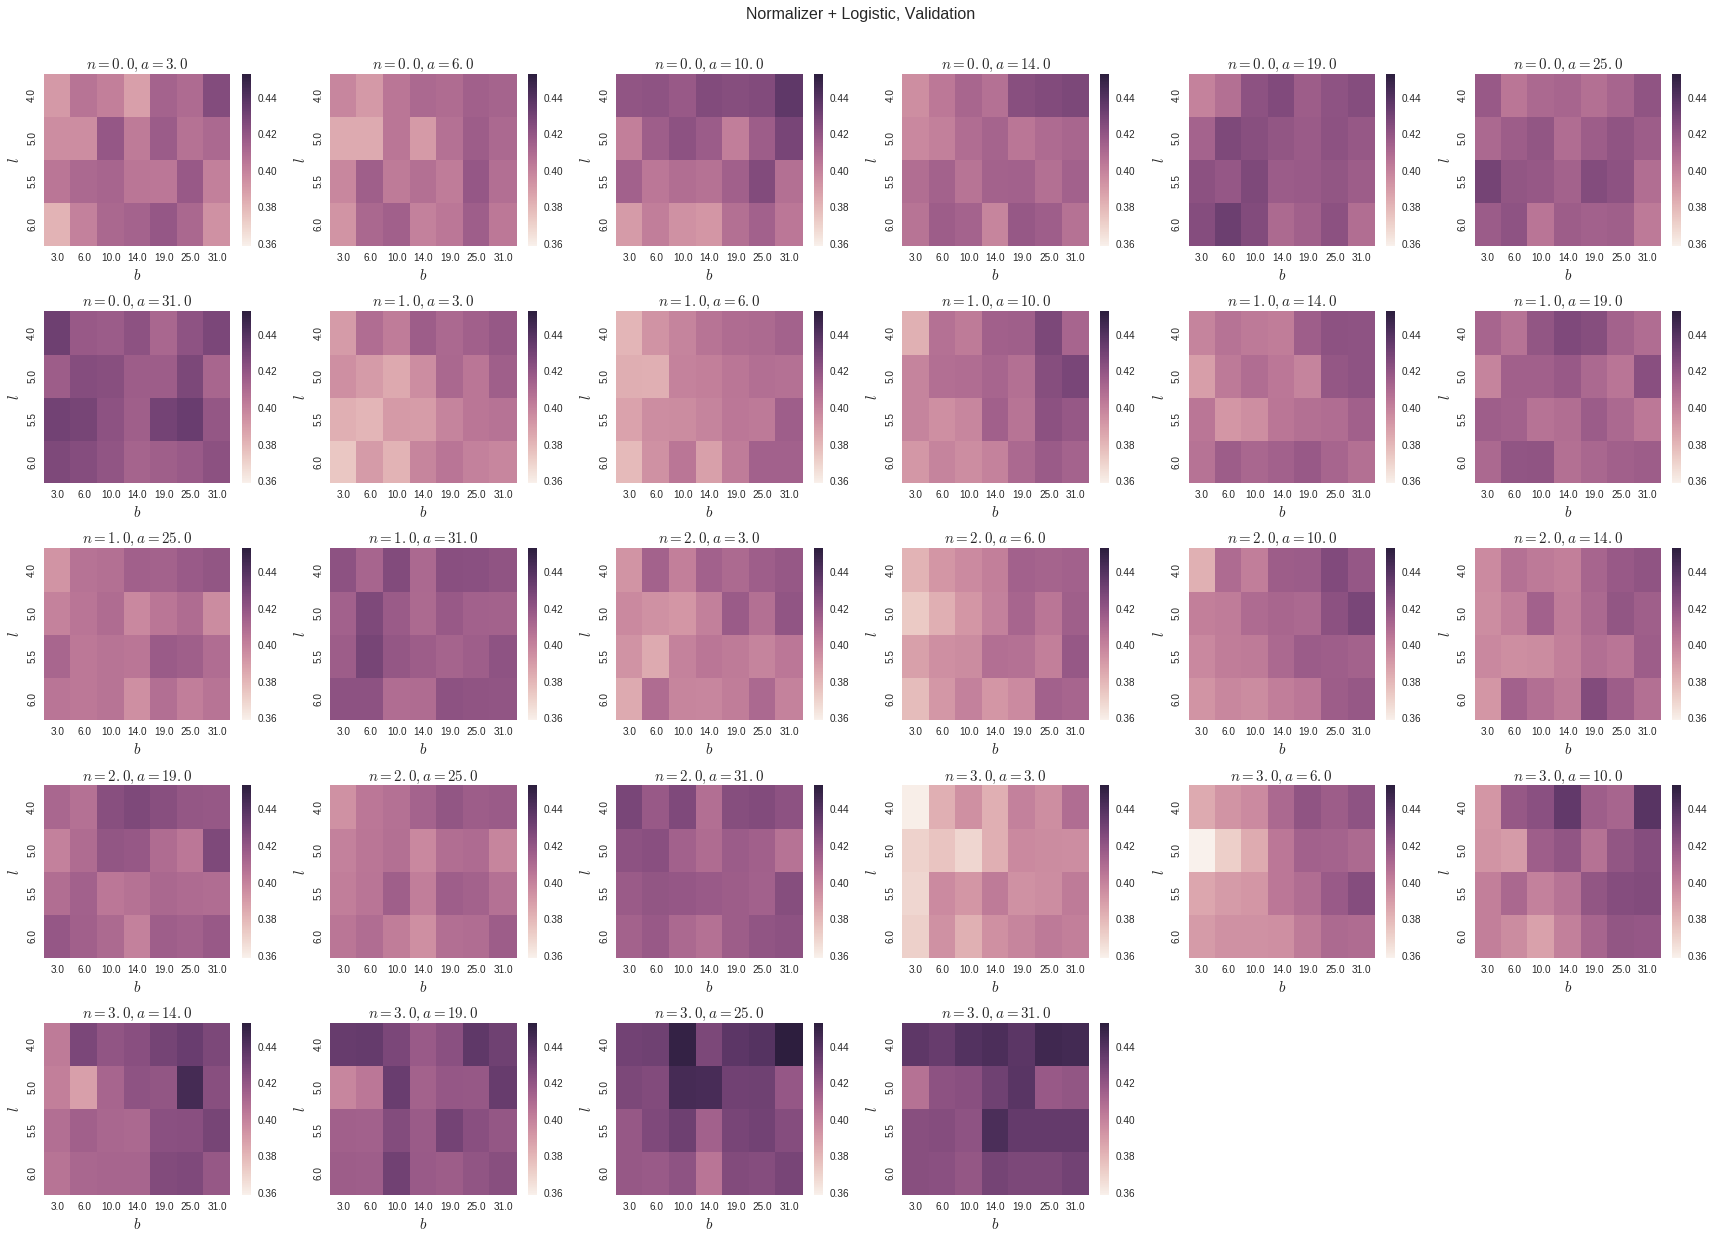

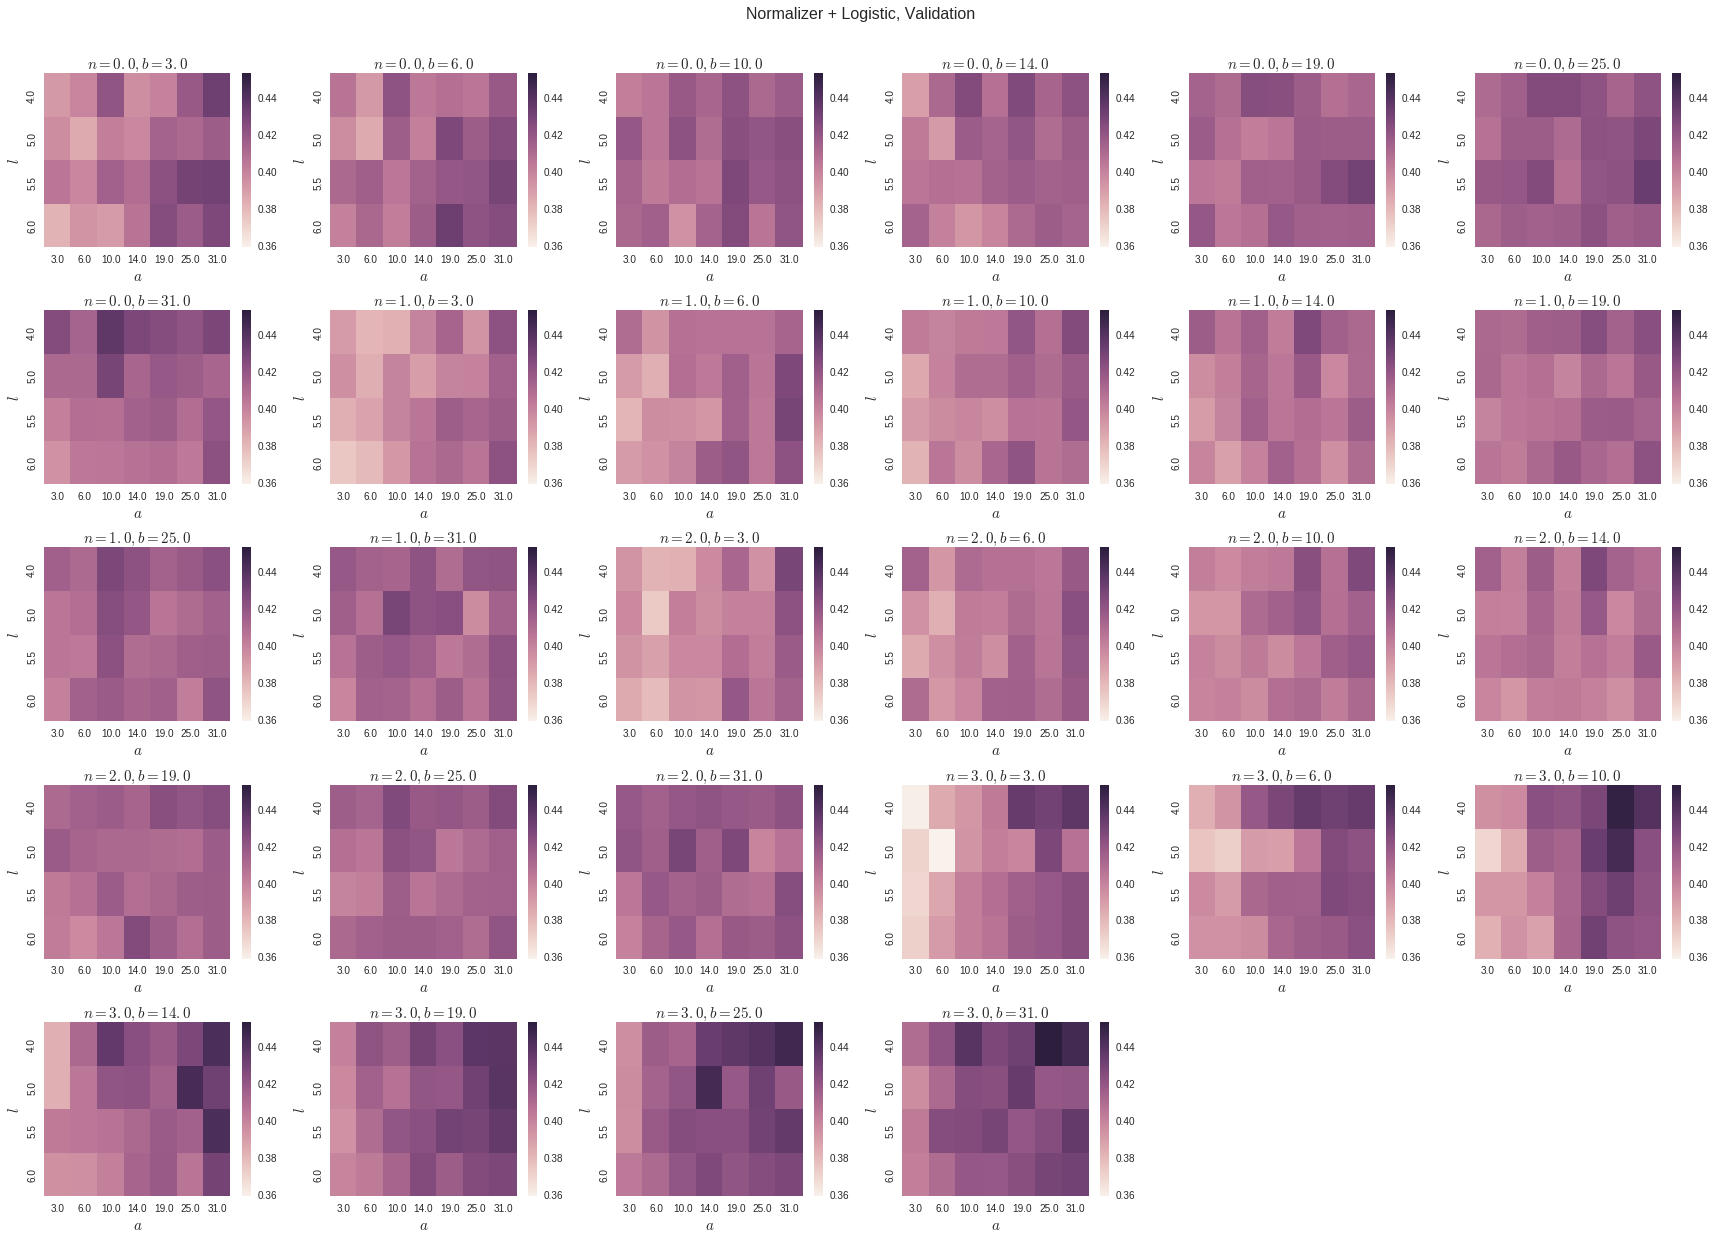

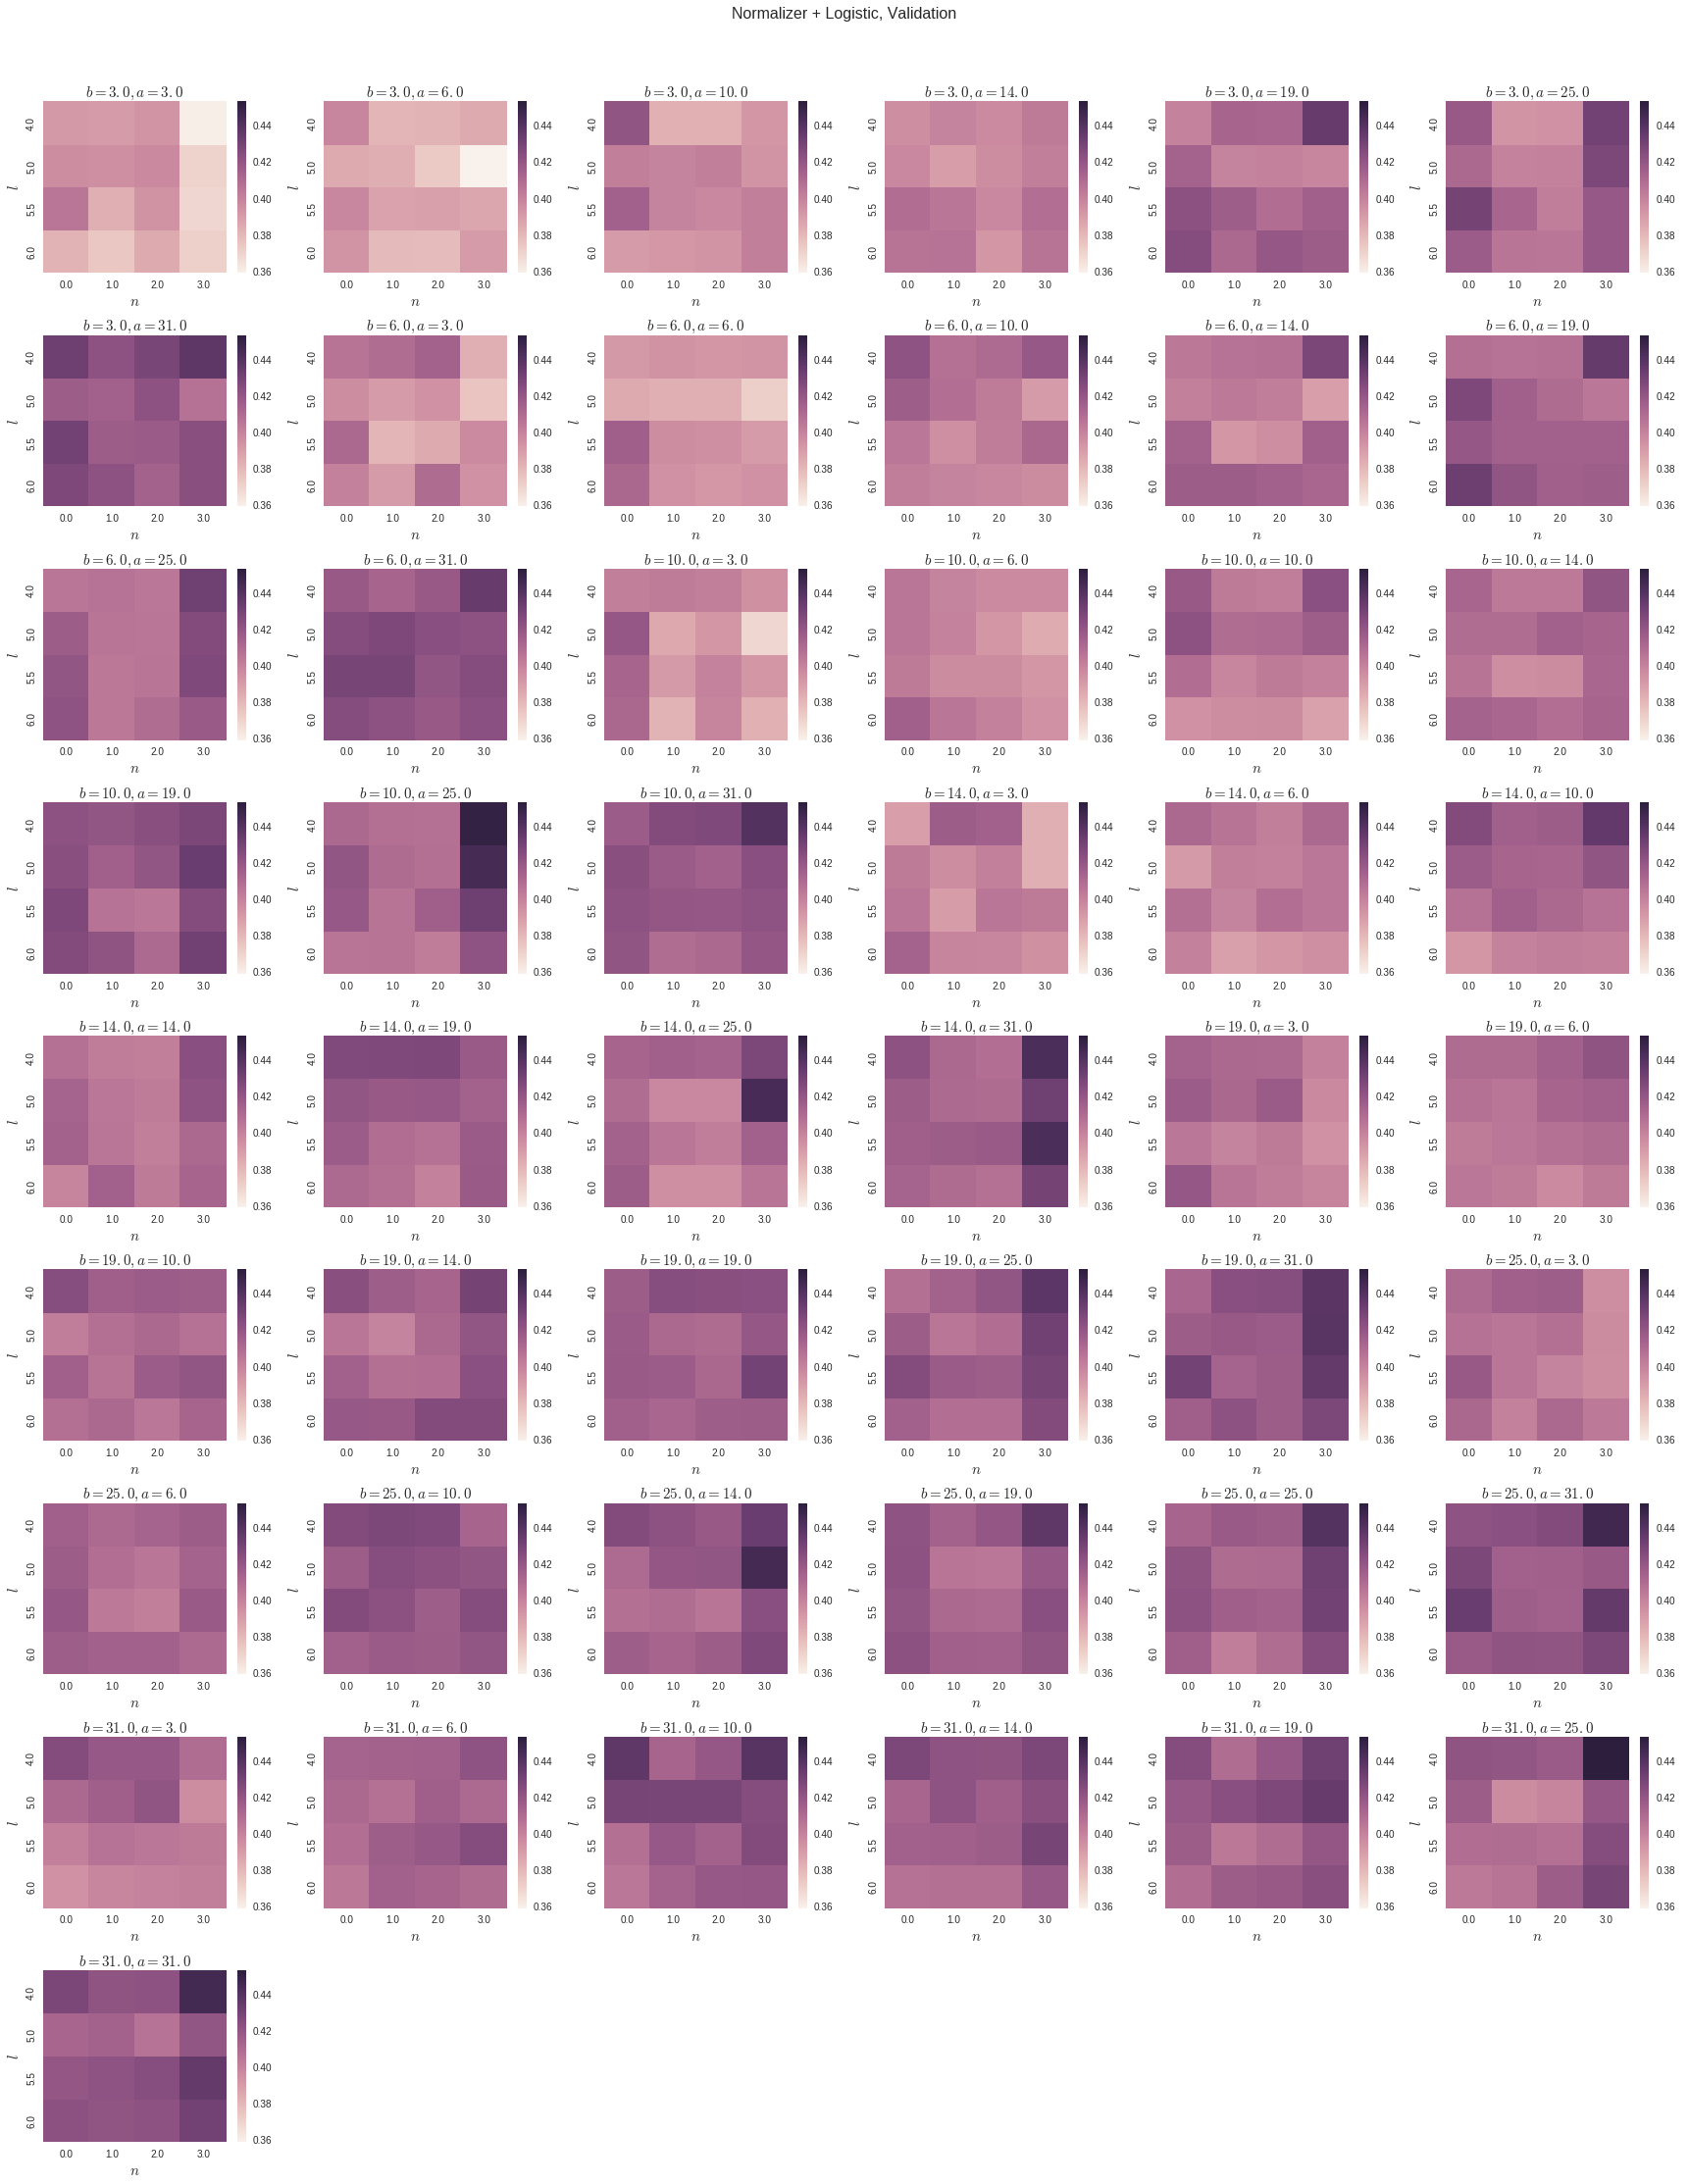

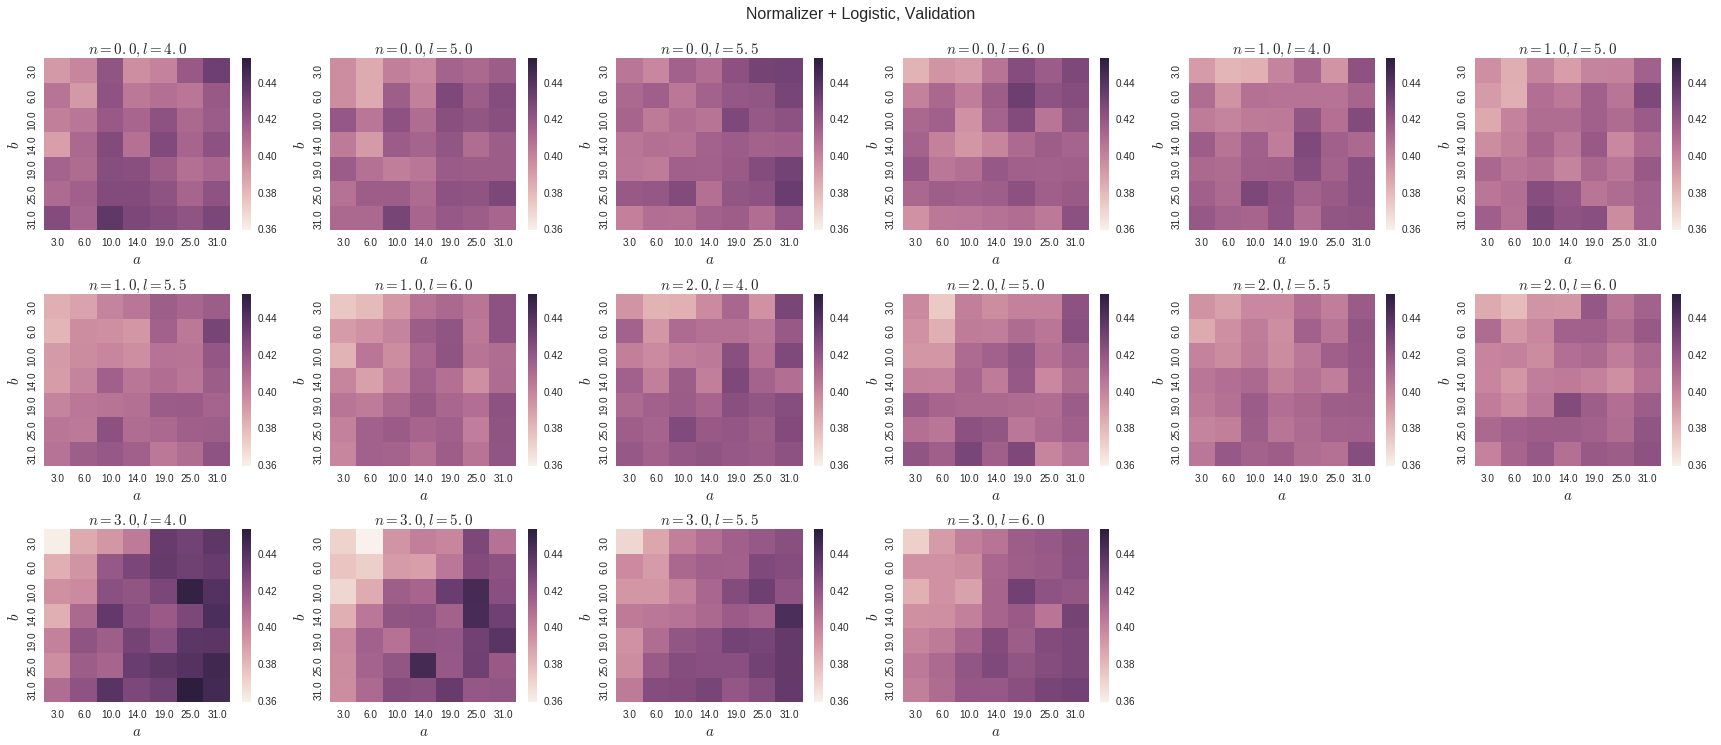

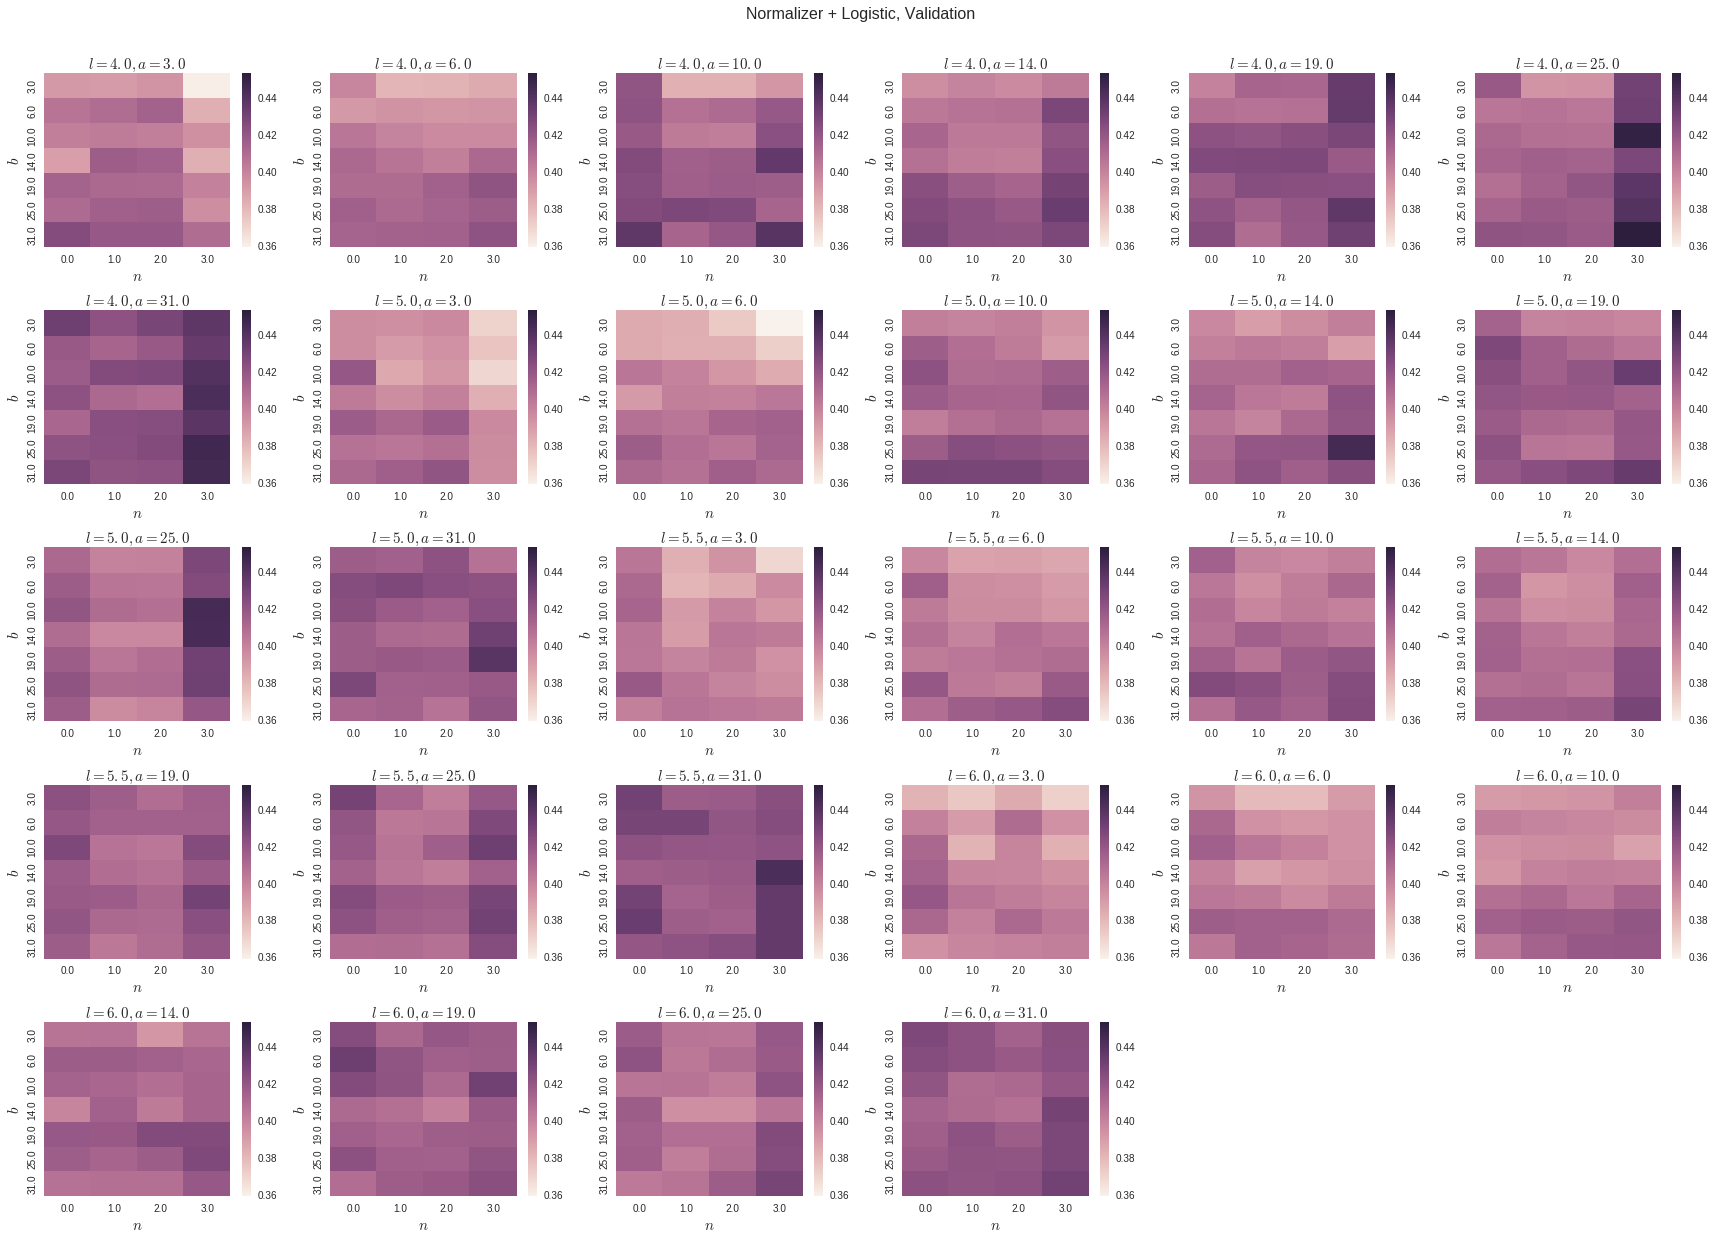

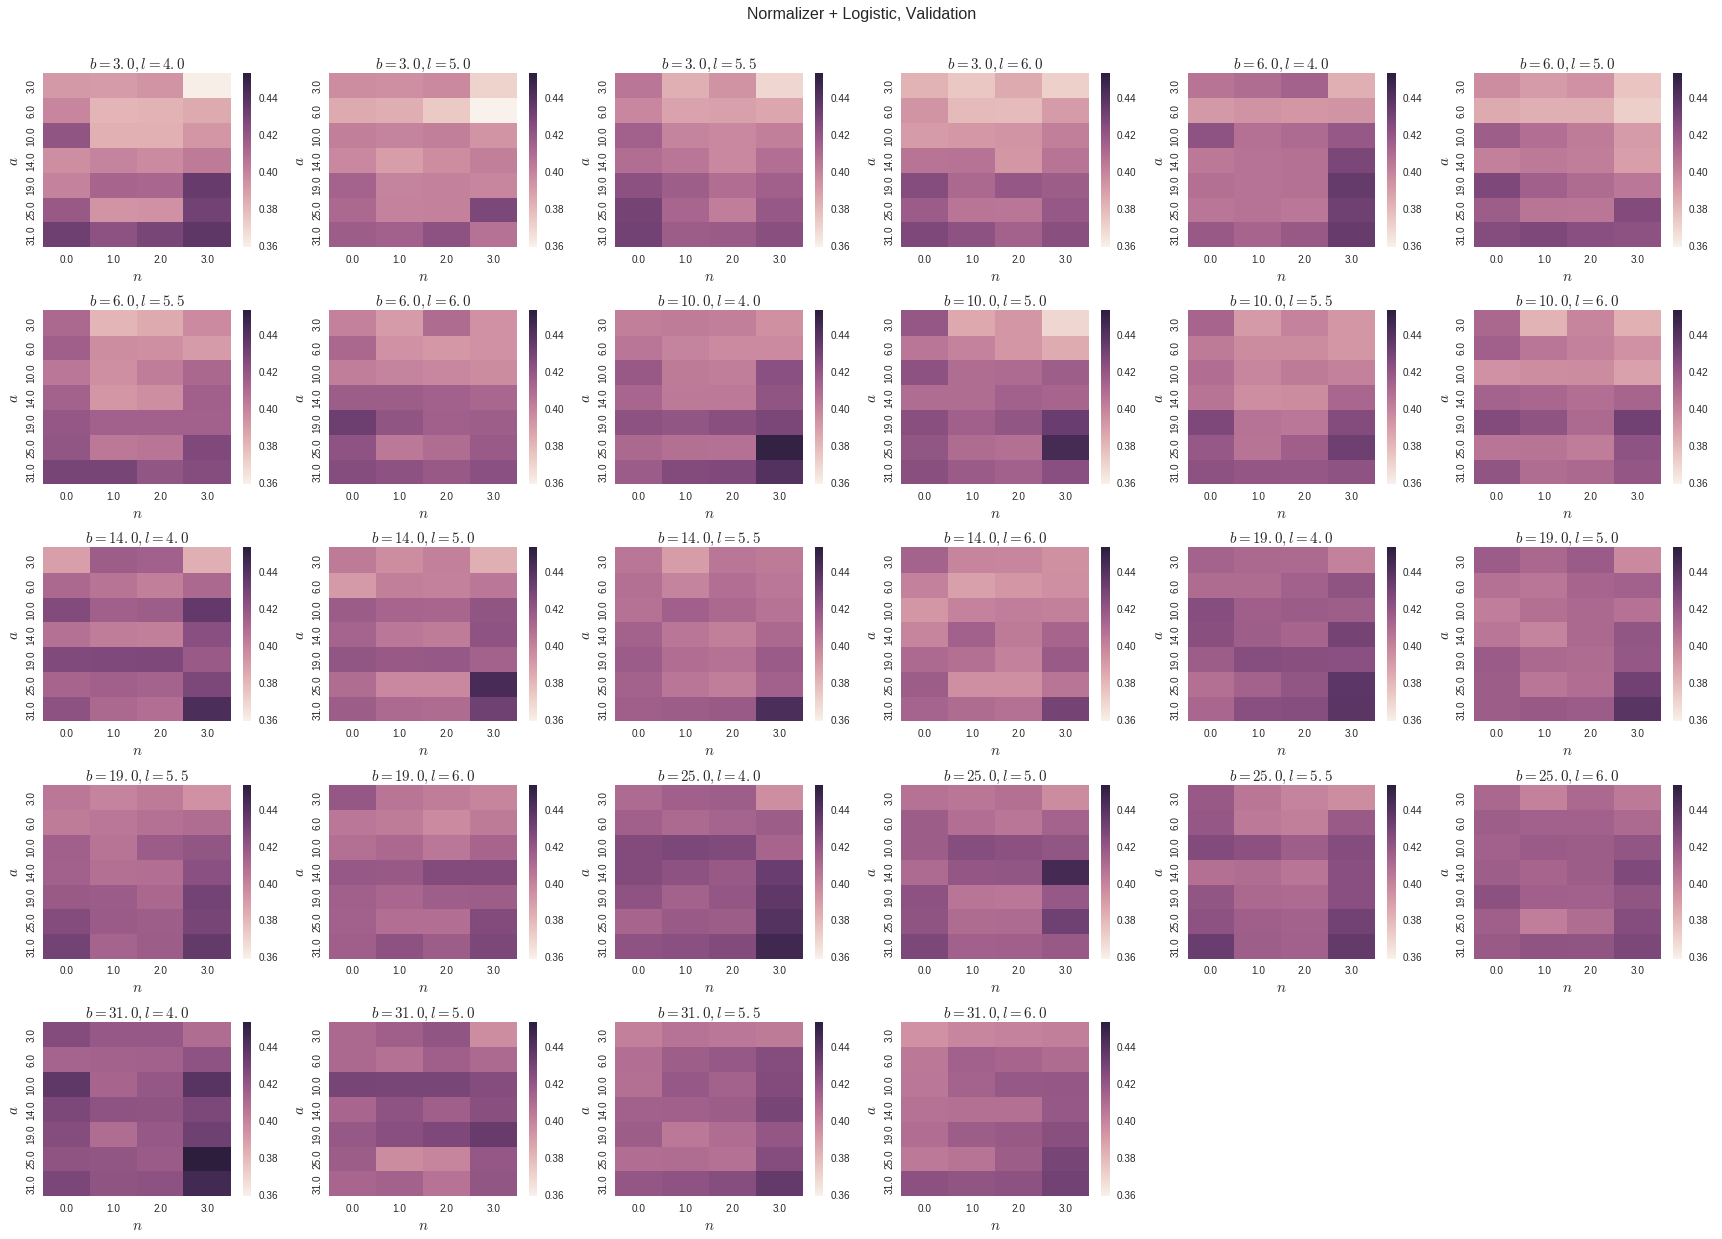

The best:
*hbonds-n3-b31-a25-l4-s0--skip_errors.mat


RMSD    TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native     123.332      133.81      132.456      133.221   
Top 1                    0.00884956  0.00442478    0.0132743    0.0132743   
Top 5                     0.0265487  0.00442478    0.0265487    0.0176991   
Mean score for top 1        9.99162    0.520116     0.411507     0.453585   
Mean loss score            -7.36503    0.192488     0.197782     0.186592   
Mean Pearson               0.167261   -0.167717    -0.188866    -0.187228   
Mean Spearman              0.125669   -0.104557    -0.138519    -0.132622   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native       124.04         195.35            99.4779   
Top 1                     0.00442478     0.00442478          0.0176991   
Top 5                      0.0176991     0.00442478          0.0575221   
Mean score for top 1        0.321847        9.99162           0.531158   
Mean loss score             0.154575        53.8435           0.223151   
Mean Pearson               -0.213939       0.167261          -0.196623   
Mean Spearman              -0.169039       0.125652          -0.160309   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                113.208                117.792   
Top 1                               0.00442478             0.00884956   
Top 5                                0.0265487               0.039823   
Mean score for top 1                  0.420301               0.463846   
Mean loss score                       0.312505               0.295004   
Mean Pearson                         -0.195398              -0.200255   
Mean Spearman                        -0.176038              -0.181661   

                        GDT-HA-score-backwards  
Mean rank of the native                115.854  
Top 1                               0.00884956  
Top 5                                0.0265487  
Mean score for top 1                  0.328077  
Mean loss score                       0.275277  
Mean Pearson                         -0.211787  
Mean Spearman                        -0.199086

In [16]:
plot_results(results_val,
             'Normalizer + Logistic', mean_top1_score,
             params, info='Validation', num_cols=6, figsize=1)

##### Correlation score 

plot_results(results_val,
             'Normalizer + Logistic', correlation_score,
             params, info='Validation', num_cols=5, figsize=1)

#### Feature normalization

##### Mean score for top 1

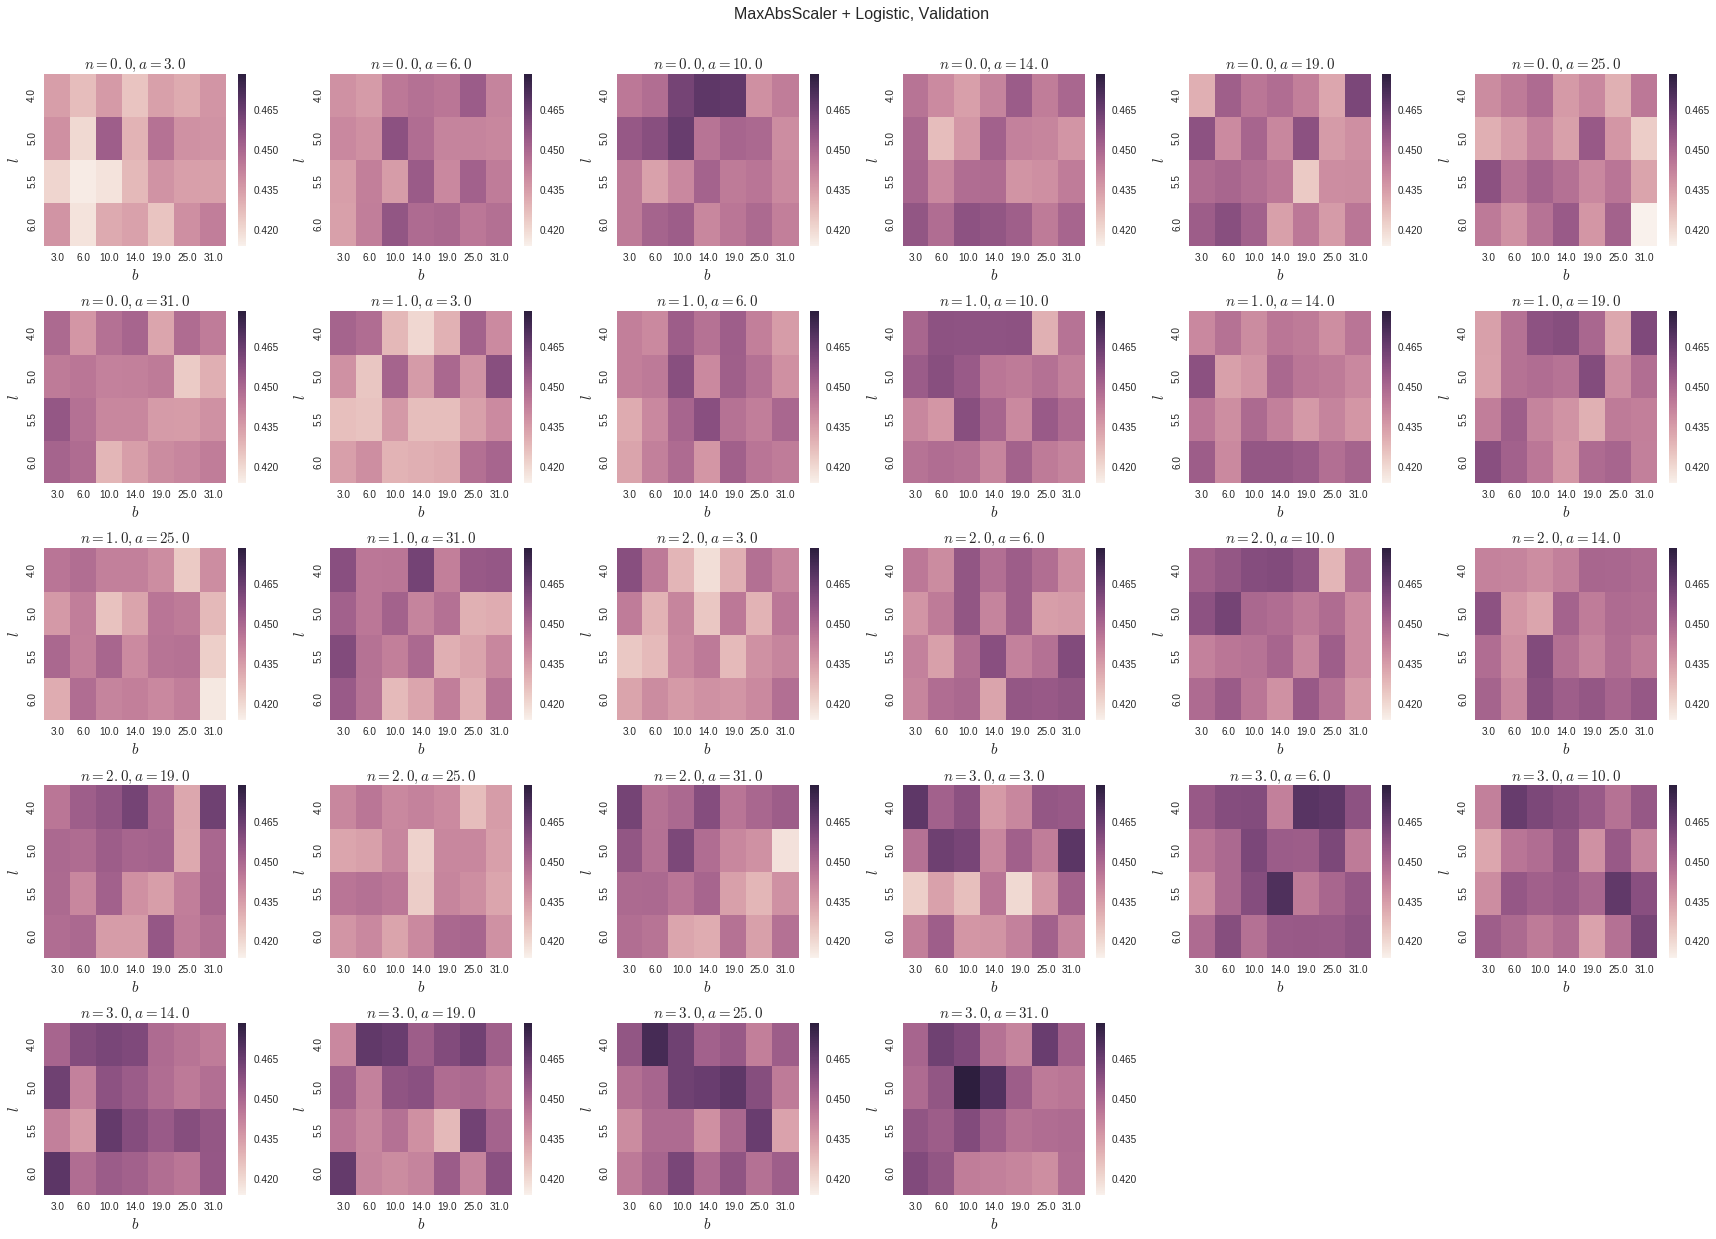

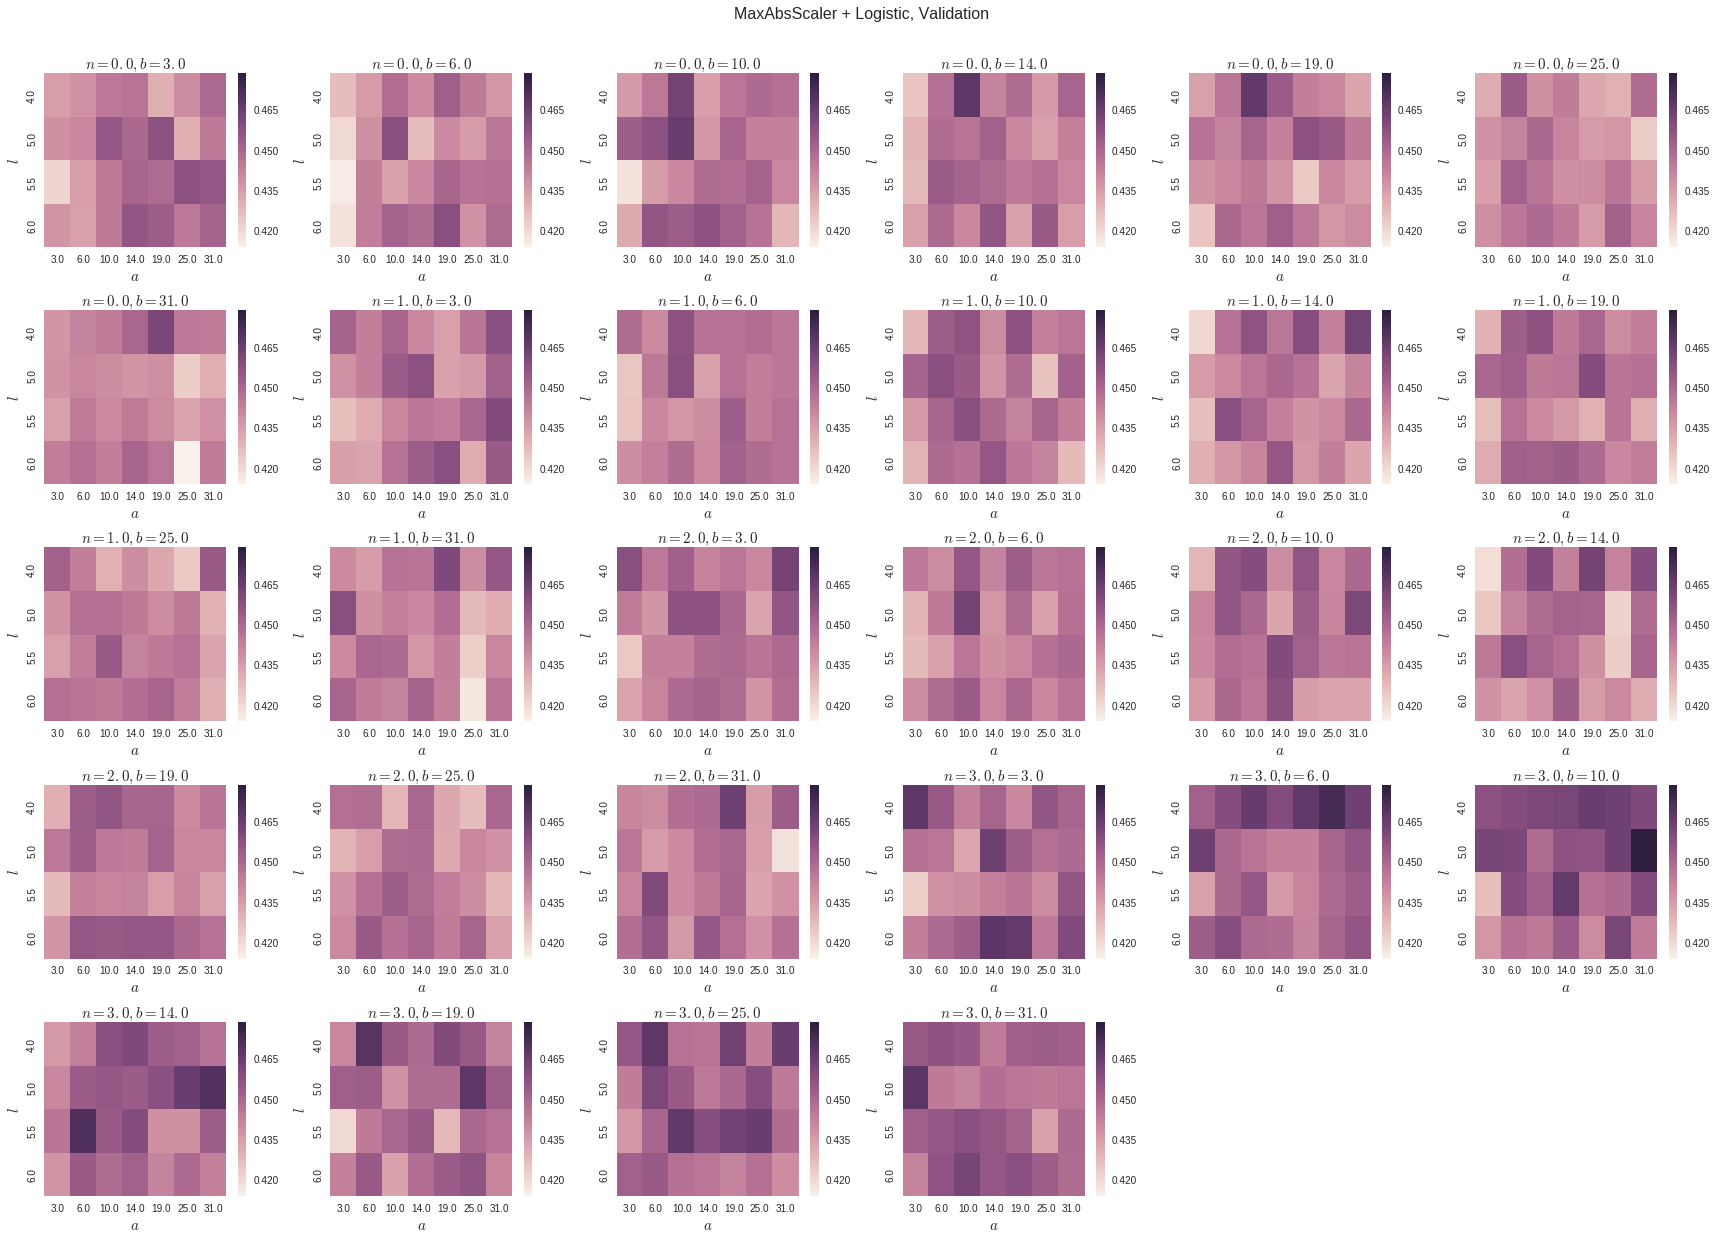

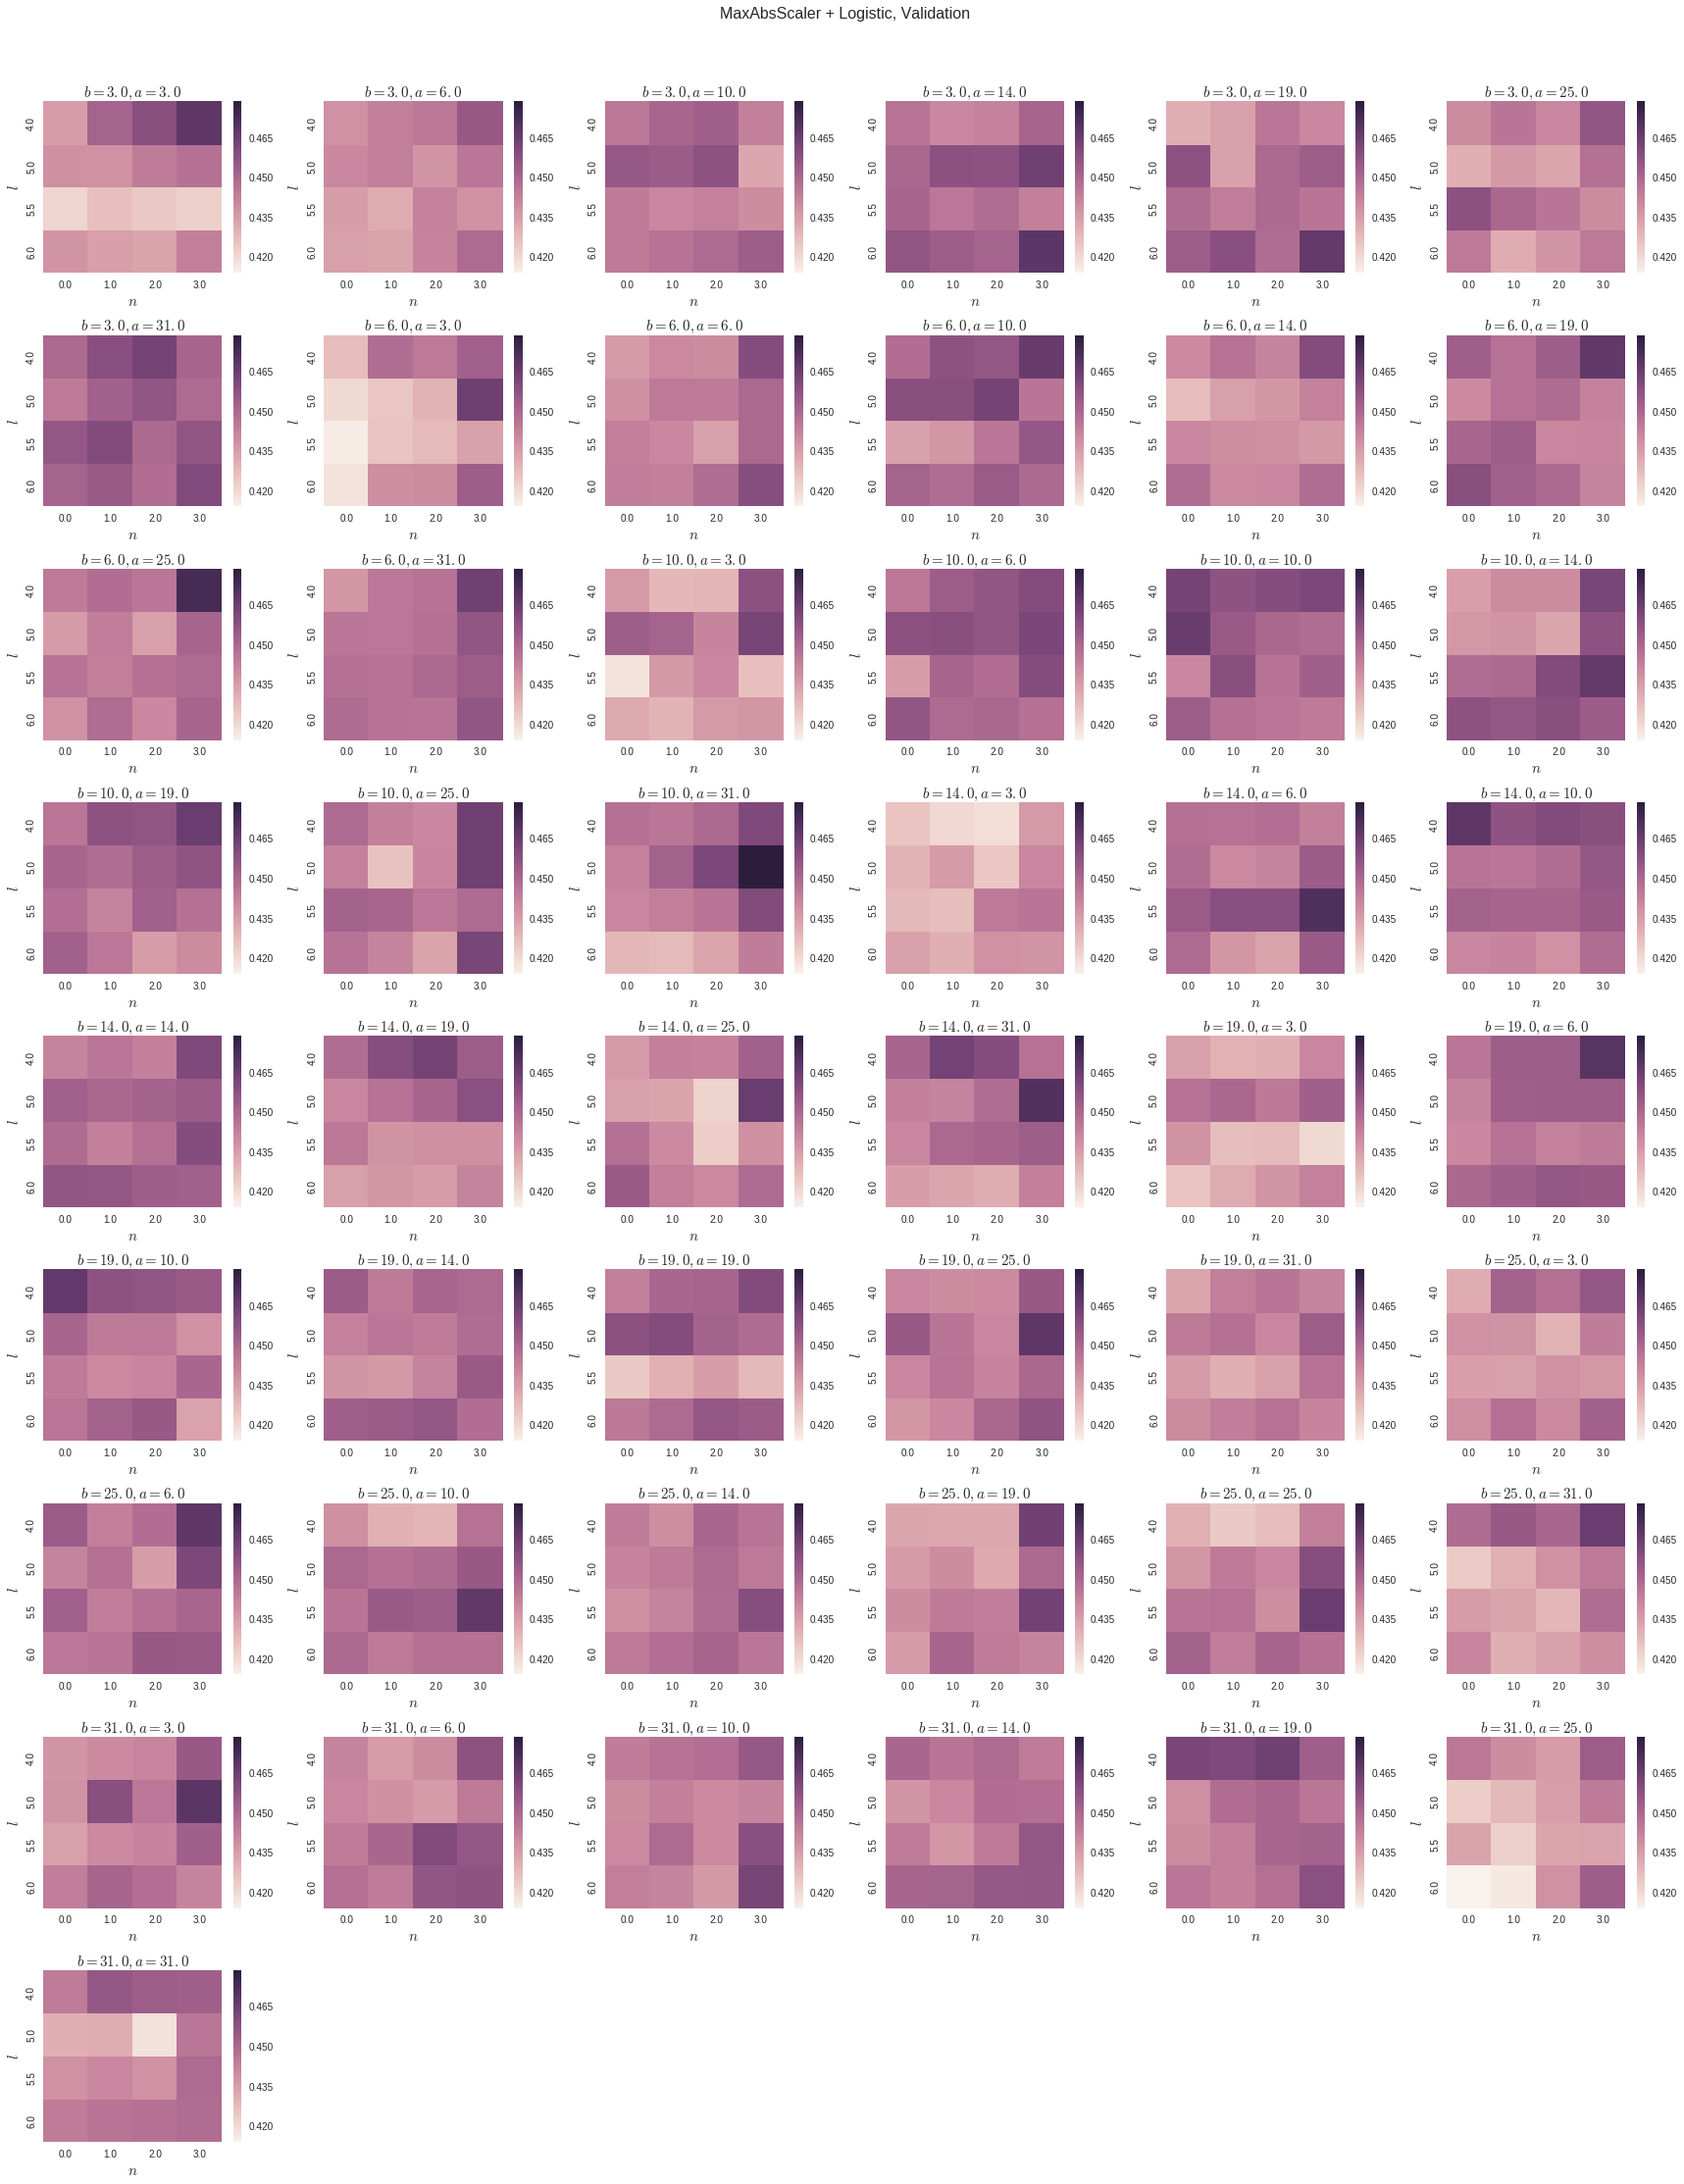

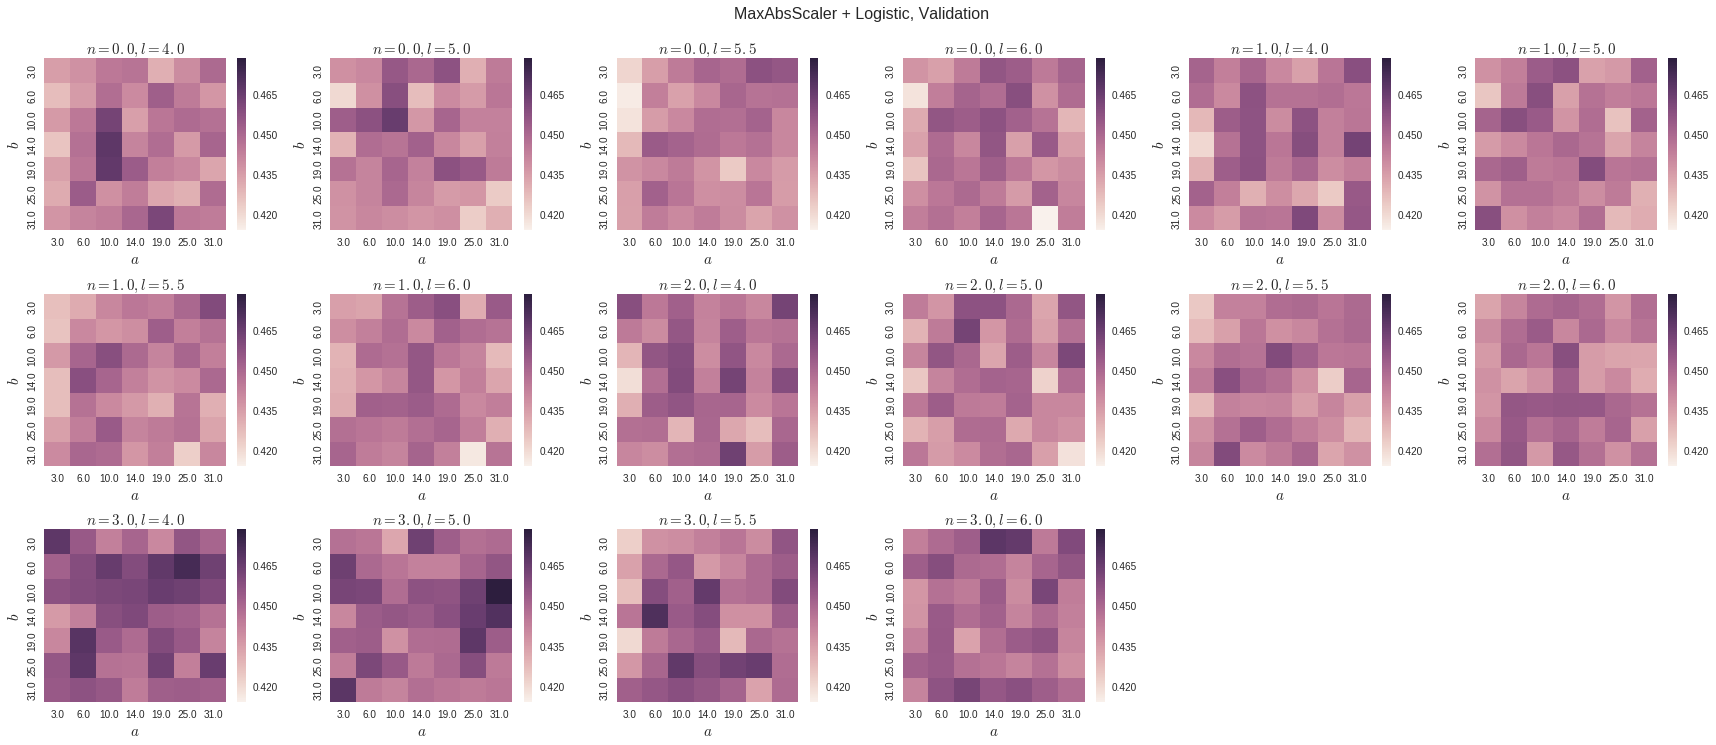

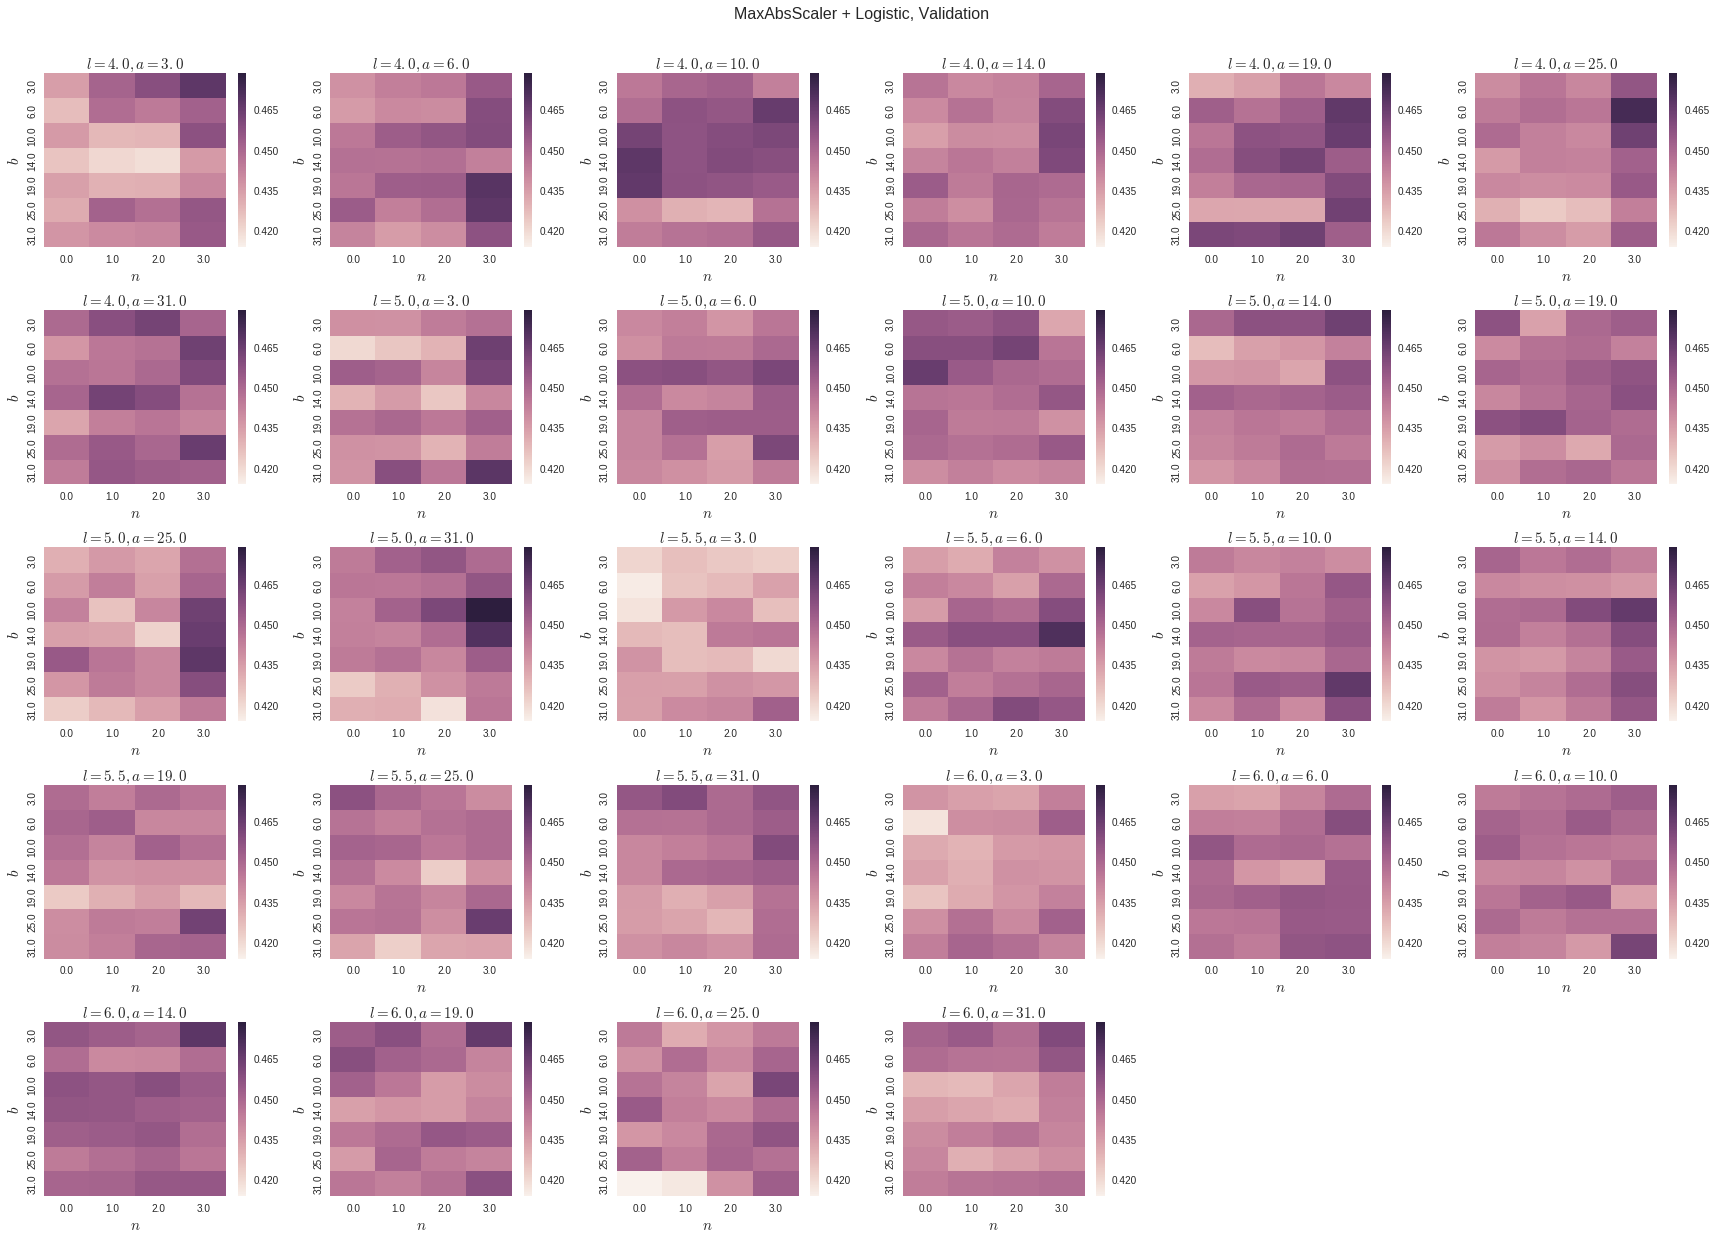

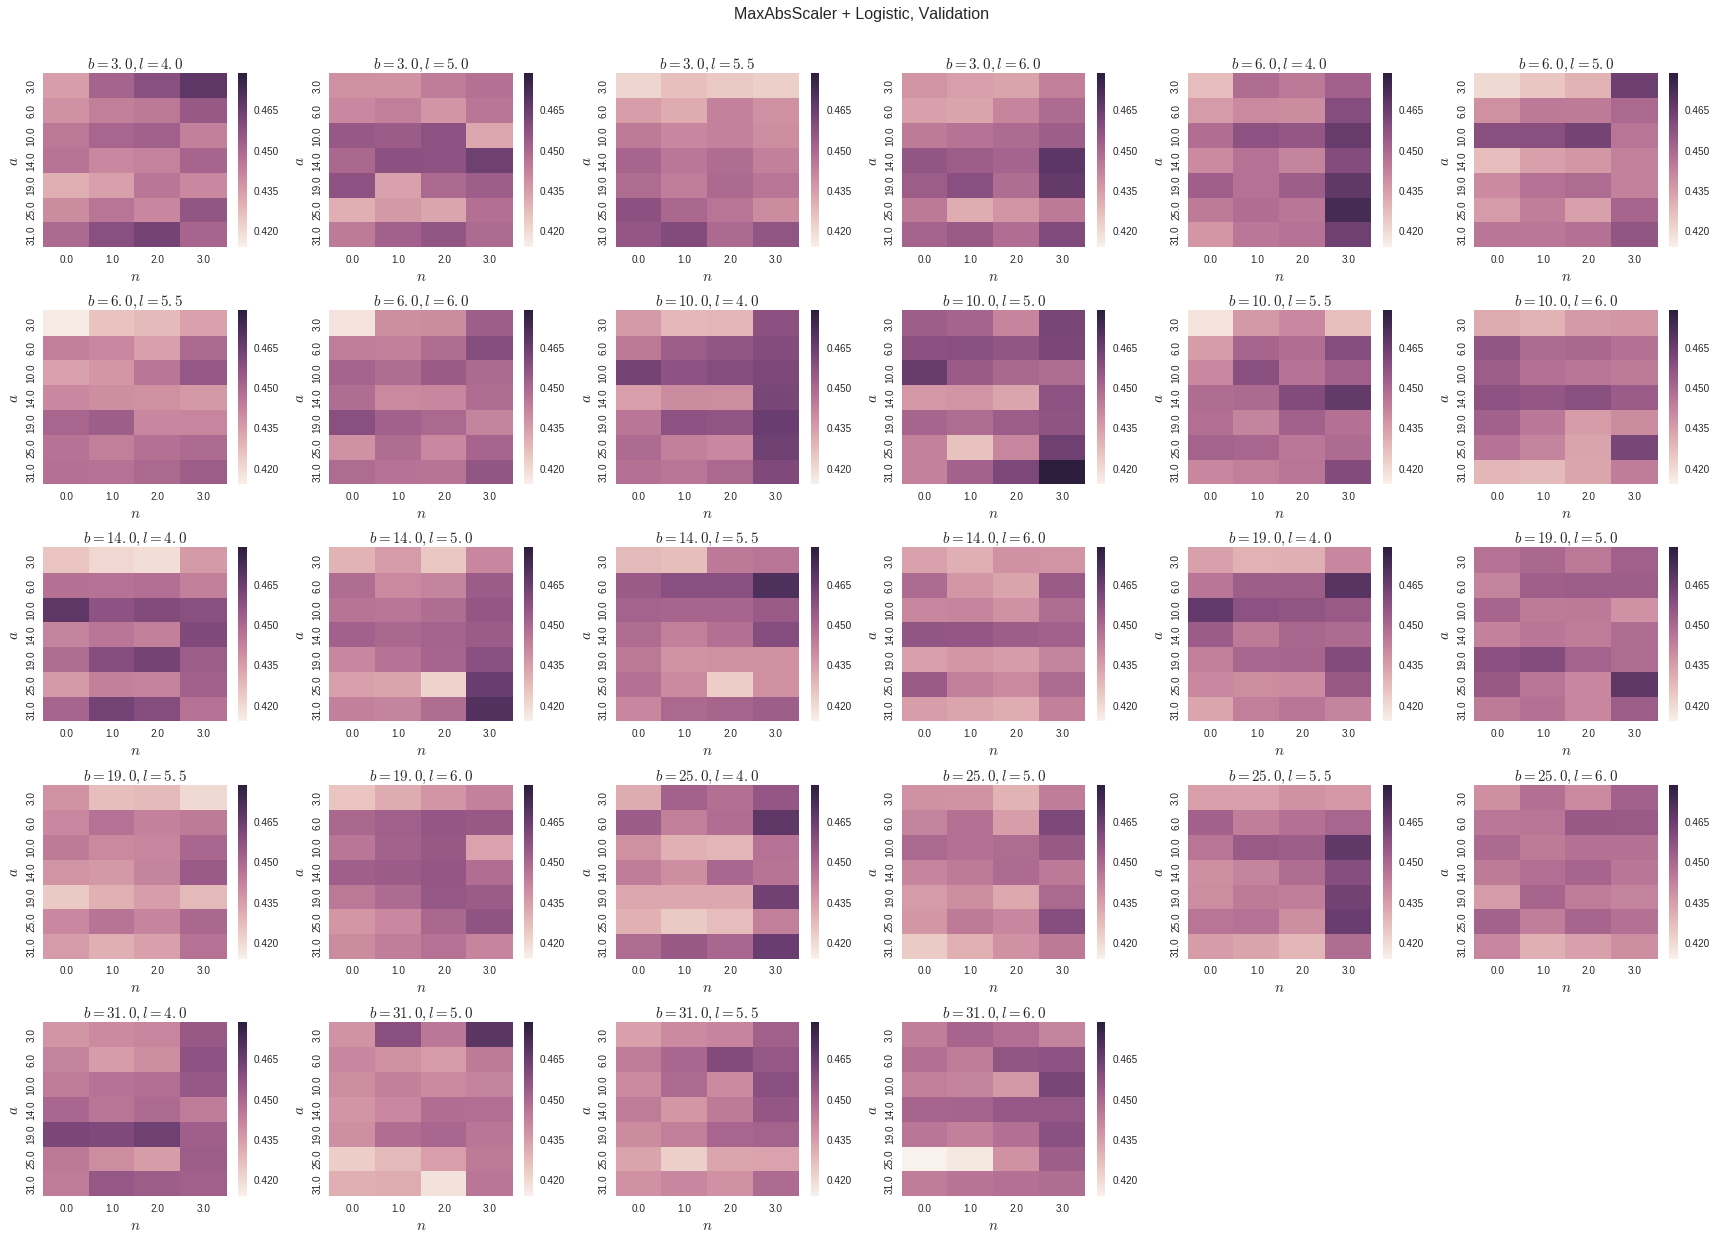

The best:
*hbonds-n3-b10-a31-l5-s0--skip_errors.mat


RMSD    TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native    88.7566     146.323      135.265      135.305   
Top 1                    0.0132743  0.00884956   0.00442478   0.00442478   
Top 5                    0.0486726   0.0176991    0.0132743    0.0132743   
Mean score for top 1       9.80458    0.542533     0.440593     0.478927   
Mean loss score           -7.17798    0.170072     0.168696      0.16125   
Mean Pearson             0.0971659  -0.0370849   -0.0973498   -0.0774979   
Mean Spearman             0.130107    0.021773   -0.0510819   -0.0289076   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      131.544         135.15            85.7168   
Top 1                     0.00884956     0.00442478         0.00884956   
Top 5                      0.0221239      0.0132743          0.0530973   
Mean score for top 1        0.345761        9.80458           0.548855   
Mean loss score             0.130662        54.0305           0.205454   
Mean Pearson                -0.11893      0.0971658          -0.148174   
Mean Spearman             -0.0809818       0.130118          -0.136869   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                75.9779                 73.615   
Top 1                               0.00442478             0.00884956   
Top 5                                0.0442478               0.039823   
Mean score for top 1                  0.443626                0.48345   
Mean loss score                       0.289181               0.275399   
Mean Pearson                         -0.209147              -0.211833   
Mean Spearman                        -0.202786              -0.209293   

                        GDT-HA-score-backwards  
Mean rank of the native                74.6991  
Top 1                               0.00442478  
Top 5                                0.0309735  
Mean score for top 1                  0.347962  
Mean loss score                       0.255392  
Mean Pearson                         -0.235828  
Mean Spearman                         -0.23386

In [17]:
plot_results(results_val,
             'MaxAbsScaler + Logistic', mean_top1_score,
             params, info='Validation', num_cols=6, figsize=1)

##### Correlation score 

plot_results(results_val,
             'MaxAbsScaler + Logistic', correlation_score,
             params, info='Validation', num_cols=5, figsize=1)

### Regression

#### Row normalization

##### Mean score for top 1

plot_results(results_val,
             'Normalizer + Ridge', mean_top1_score,
             params, info='Validation', num_cols=5, figsize=1)

##### Correlation score 

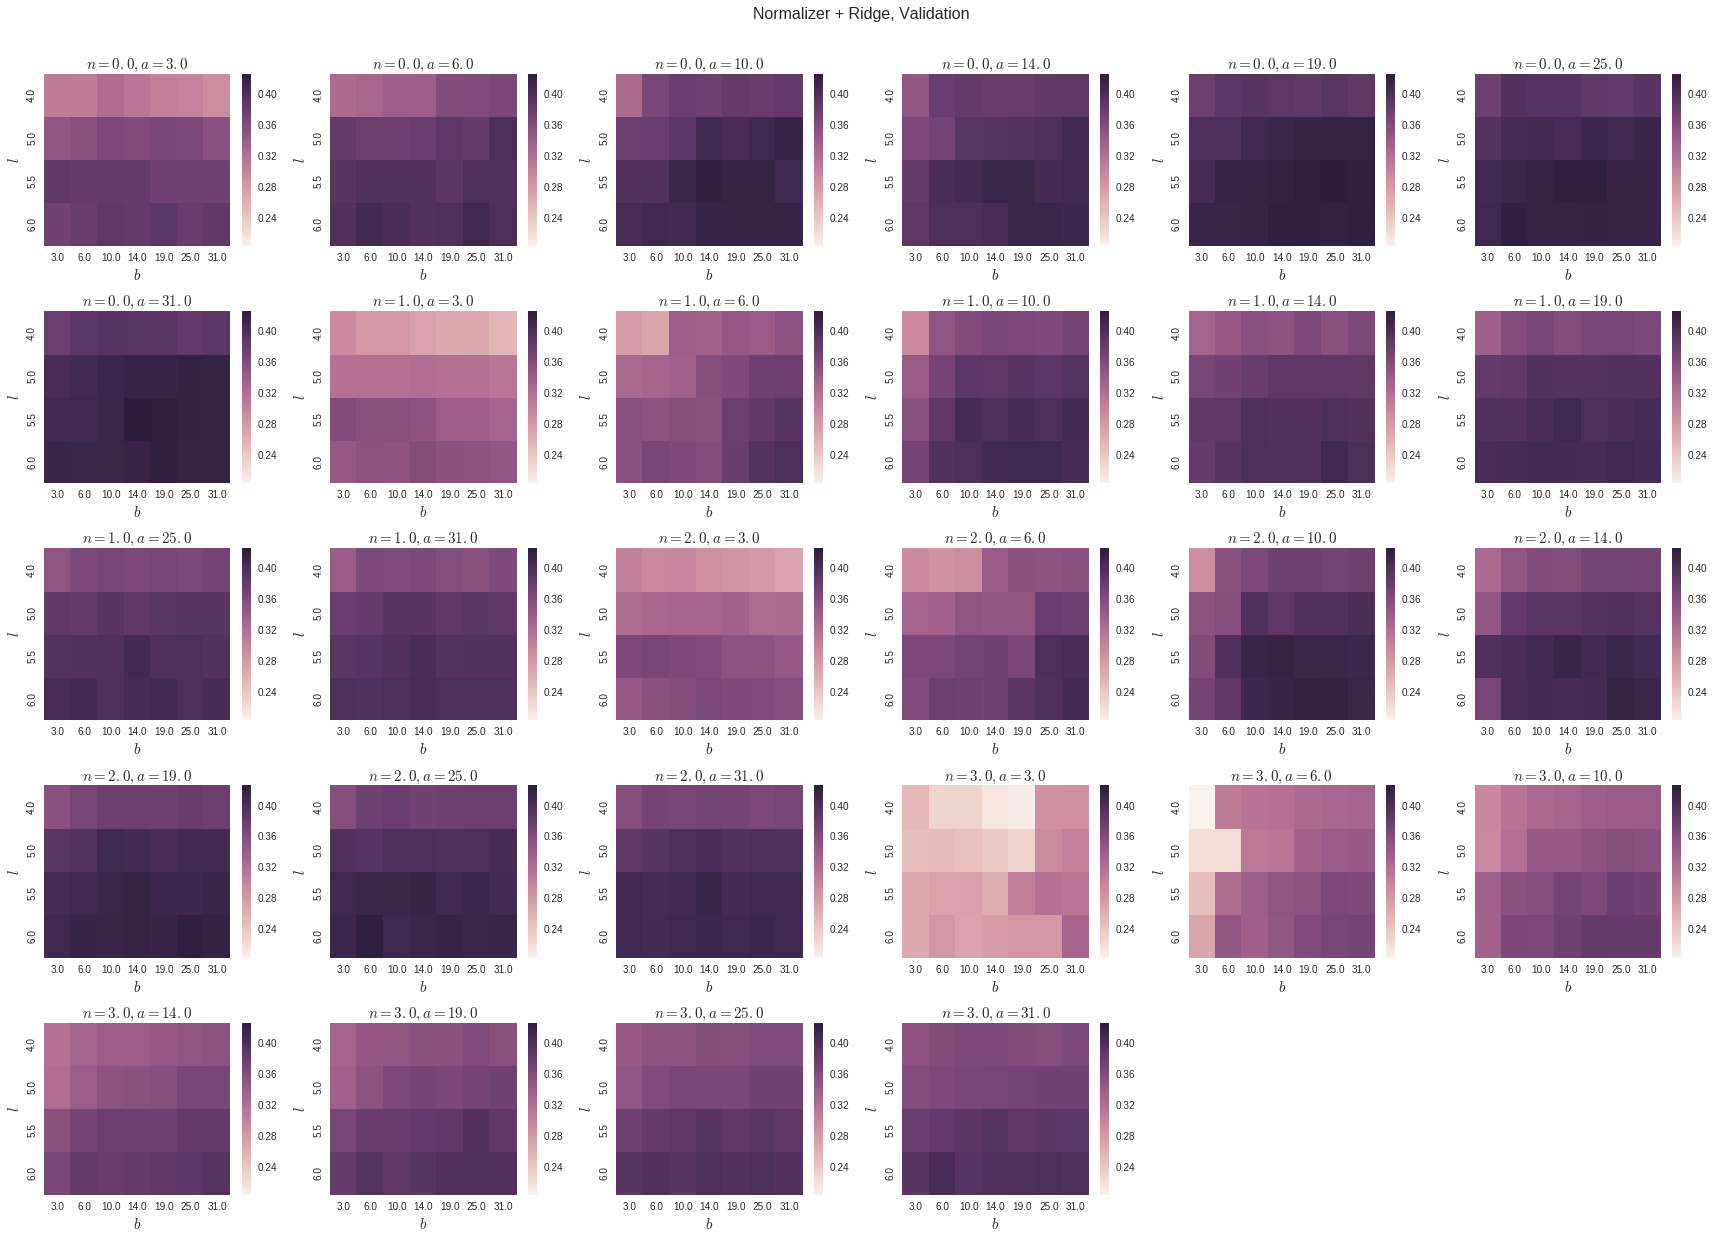

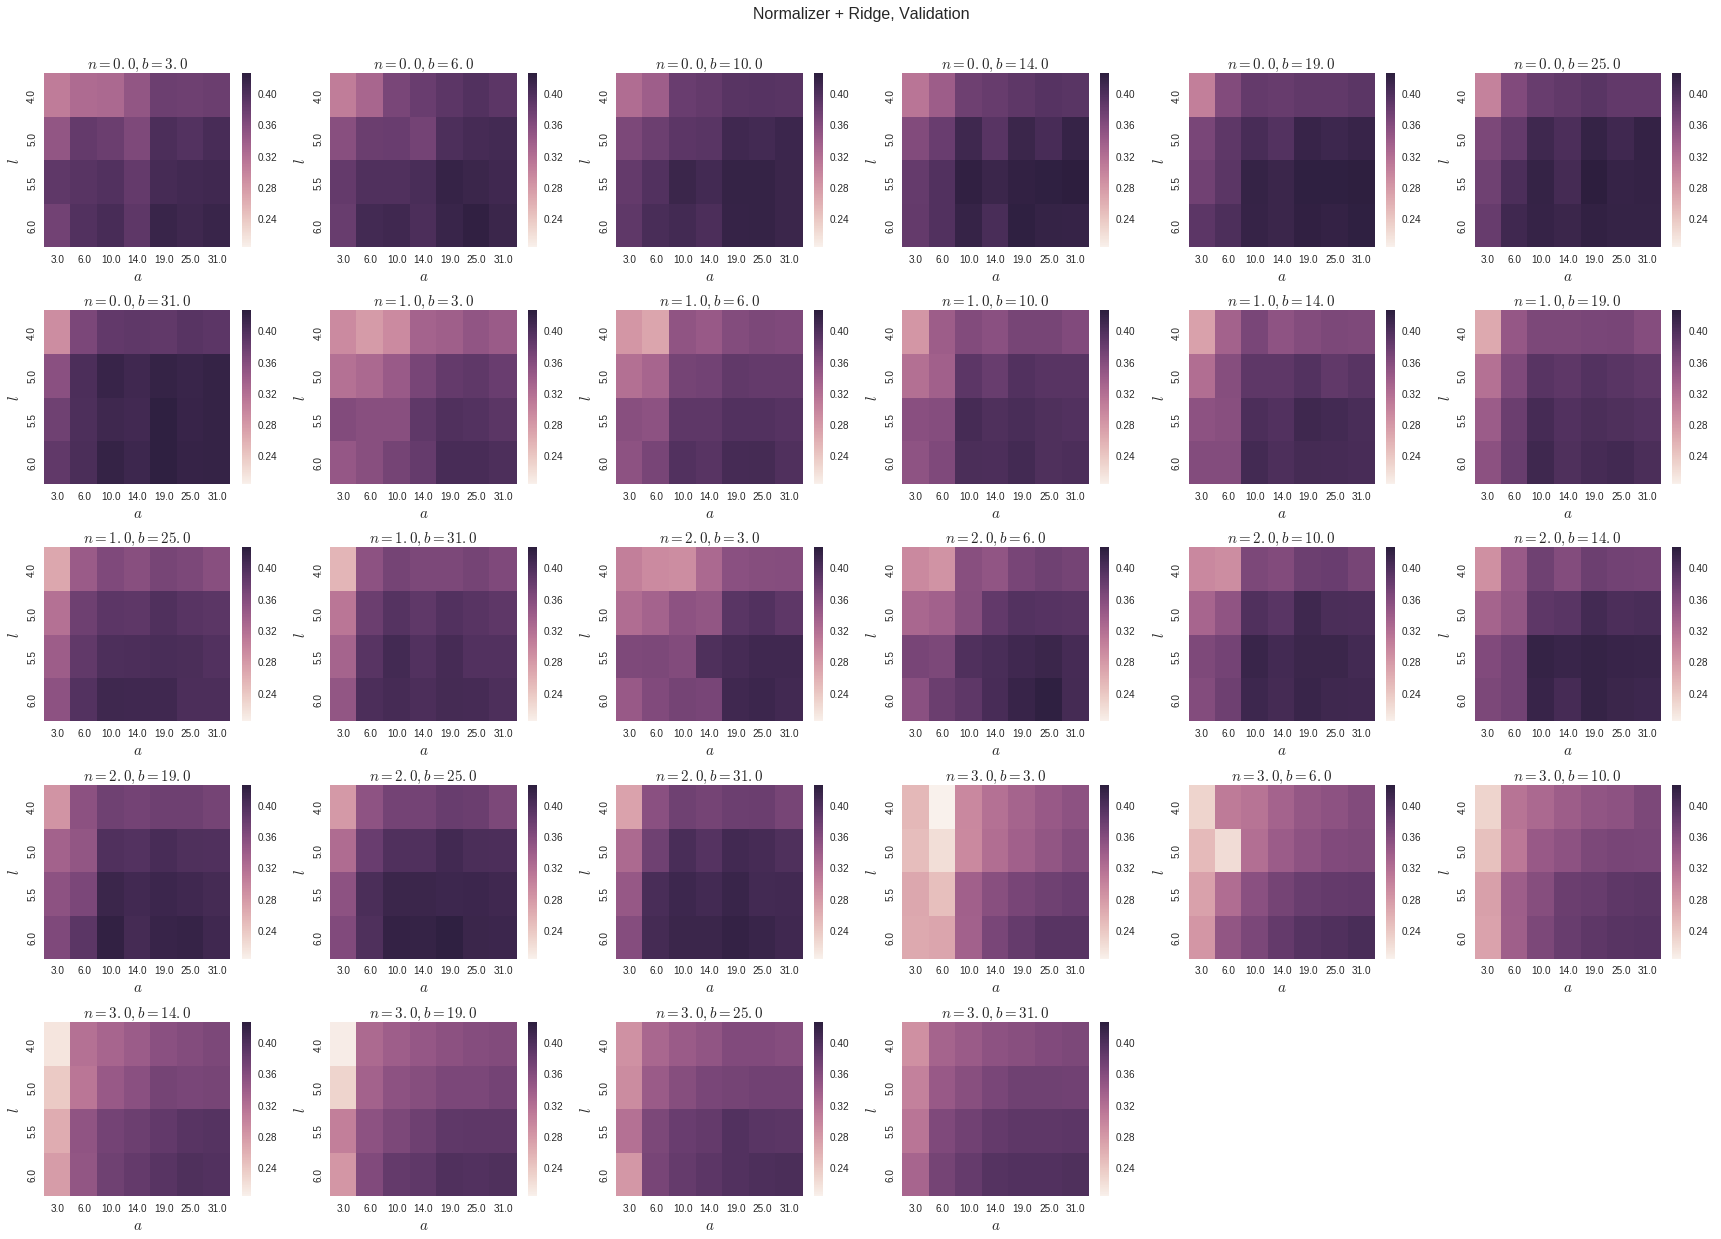

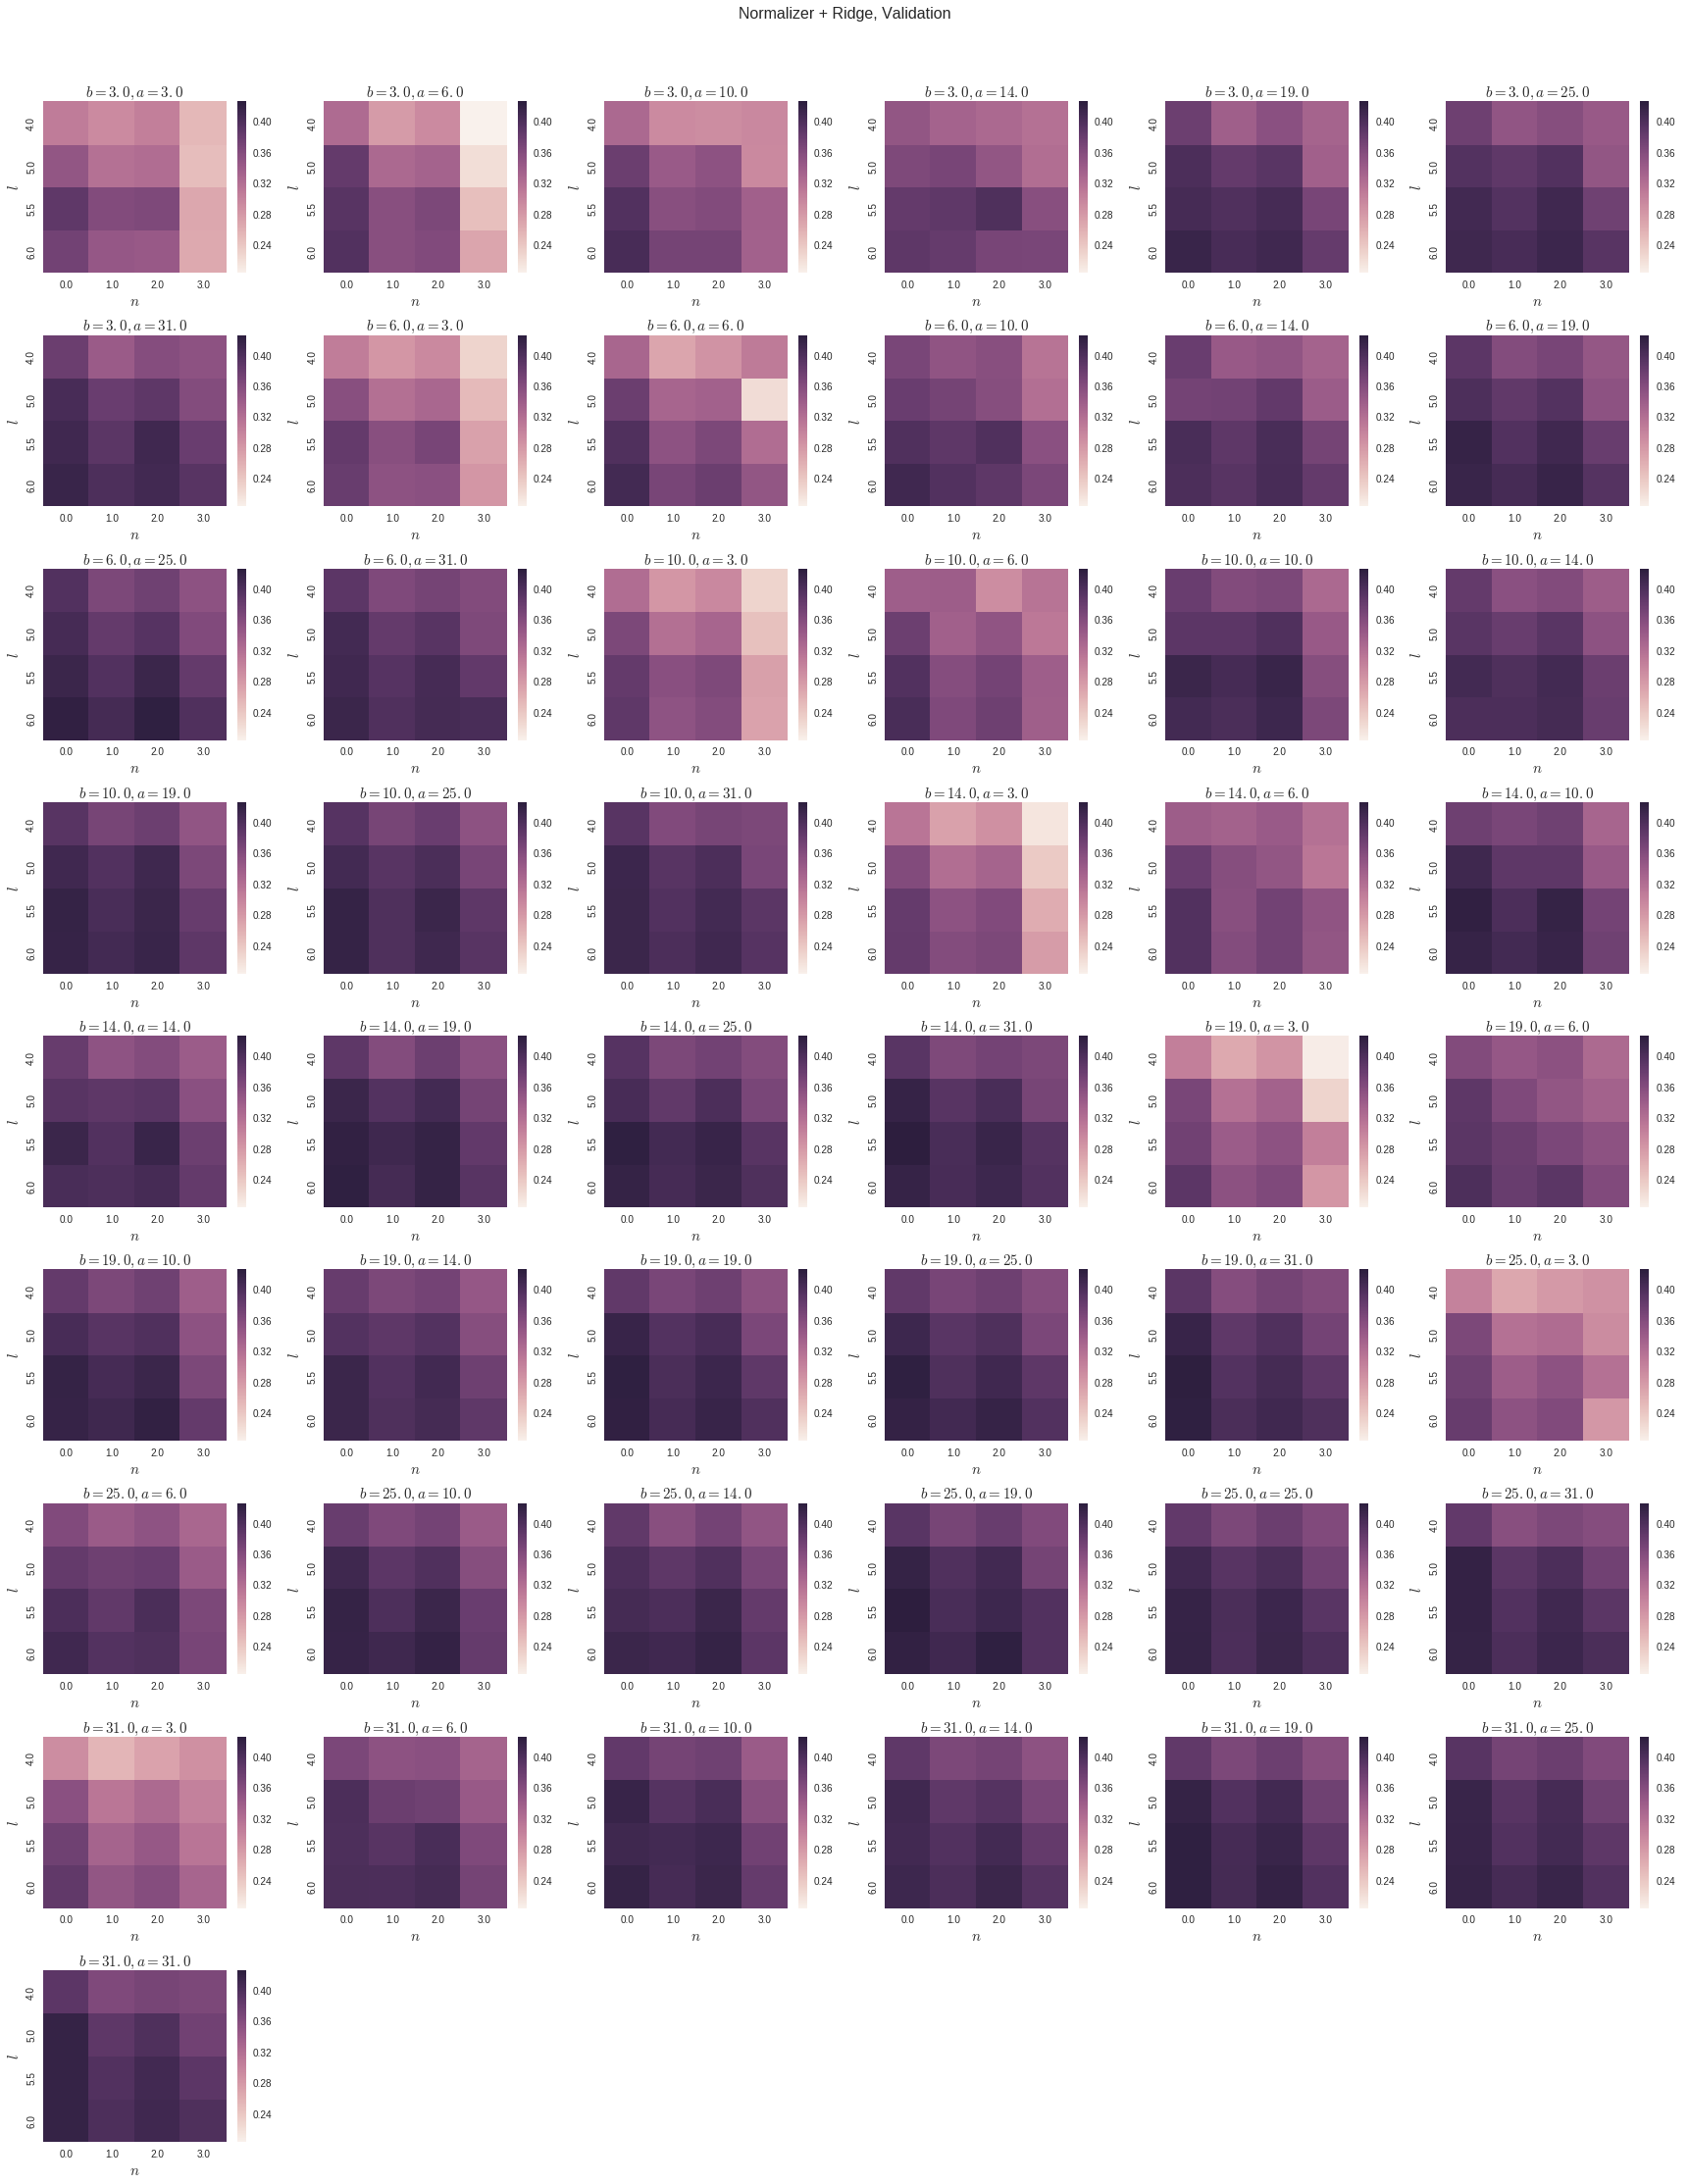

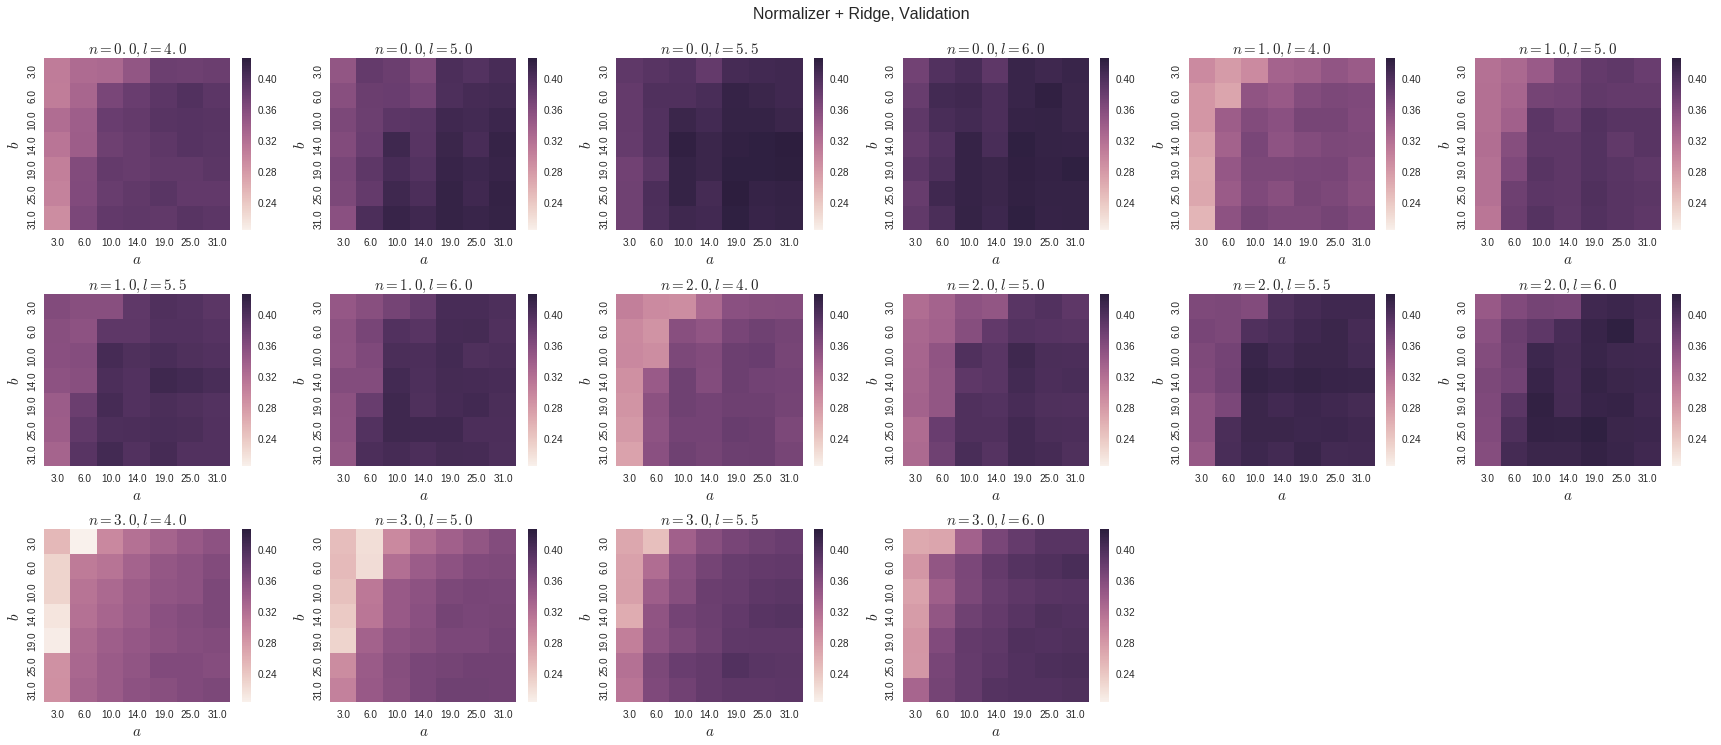

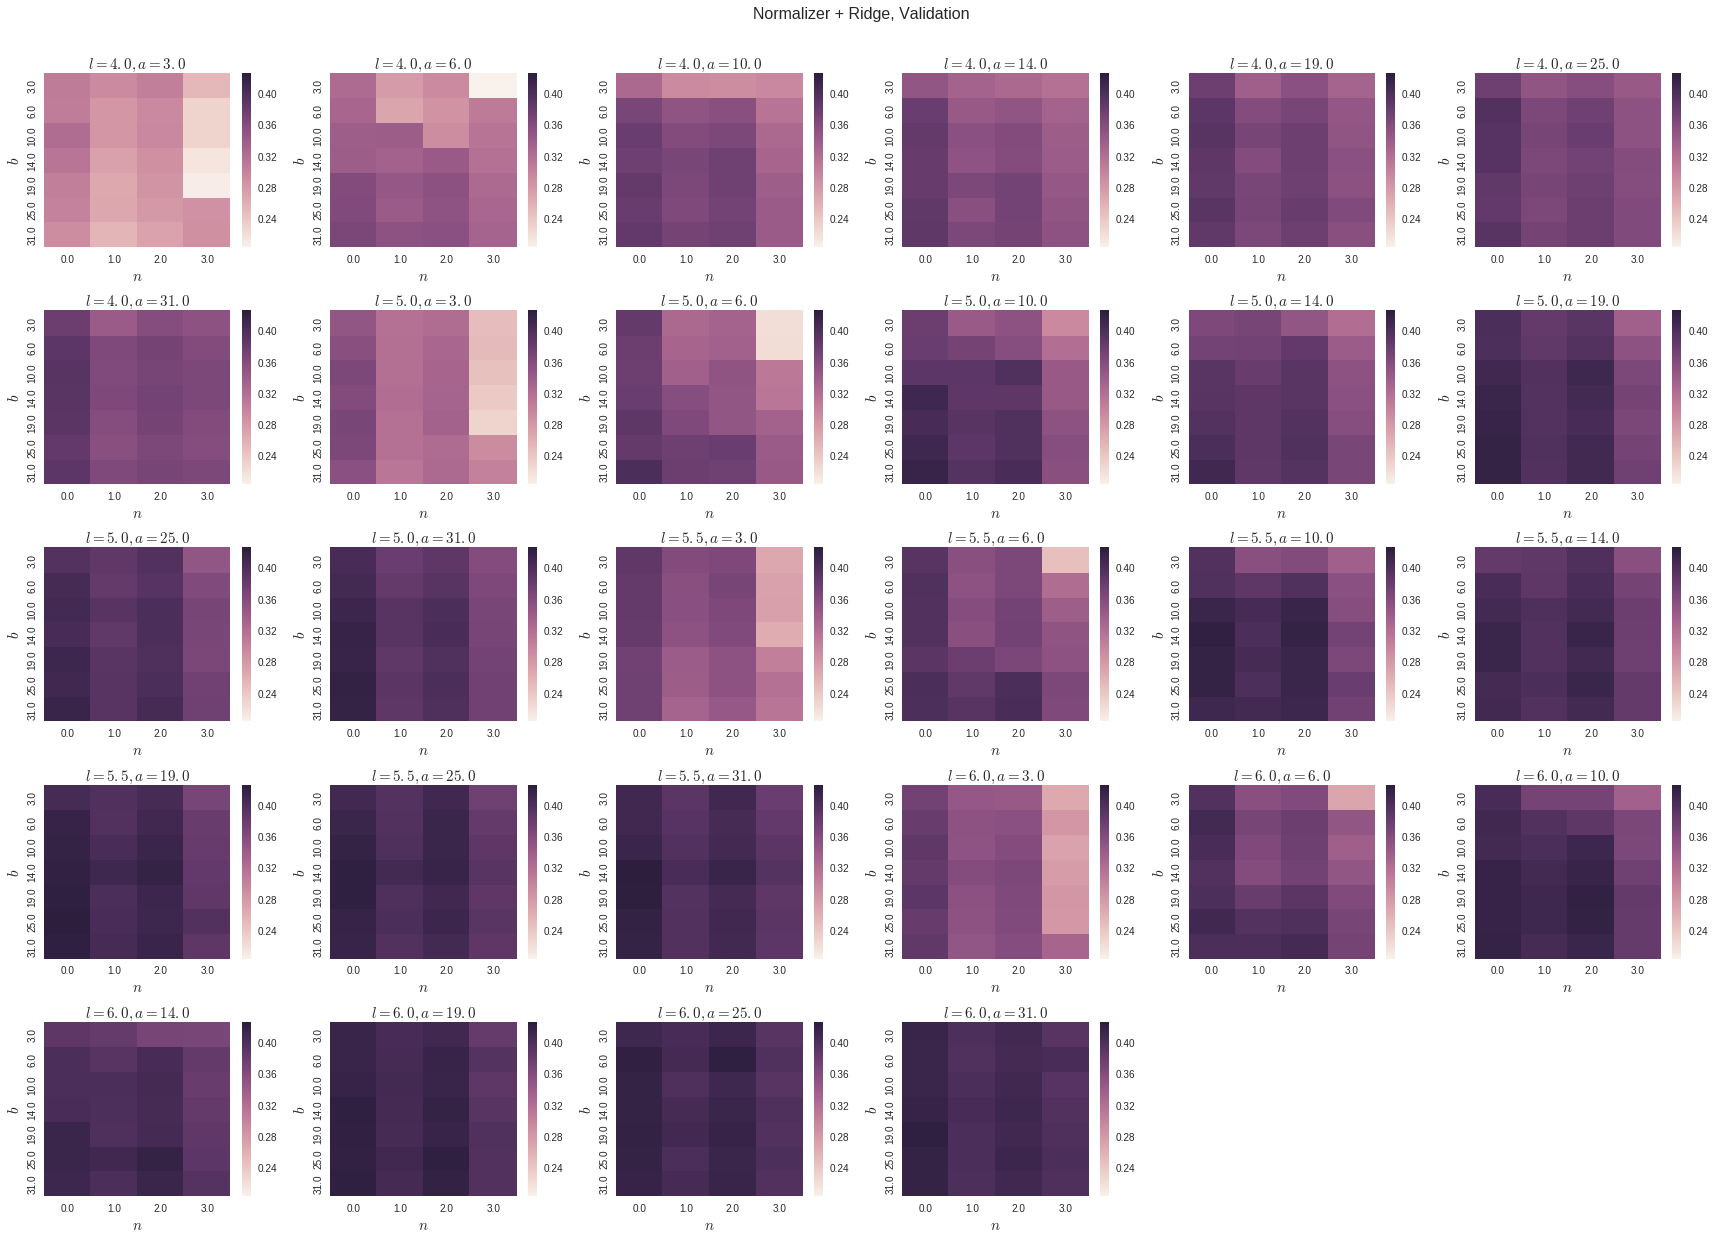

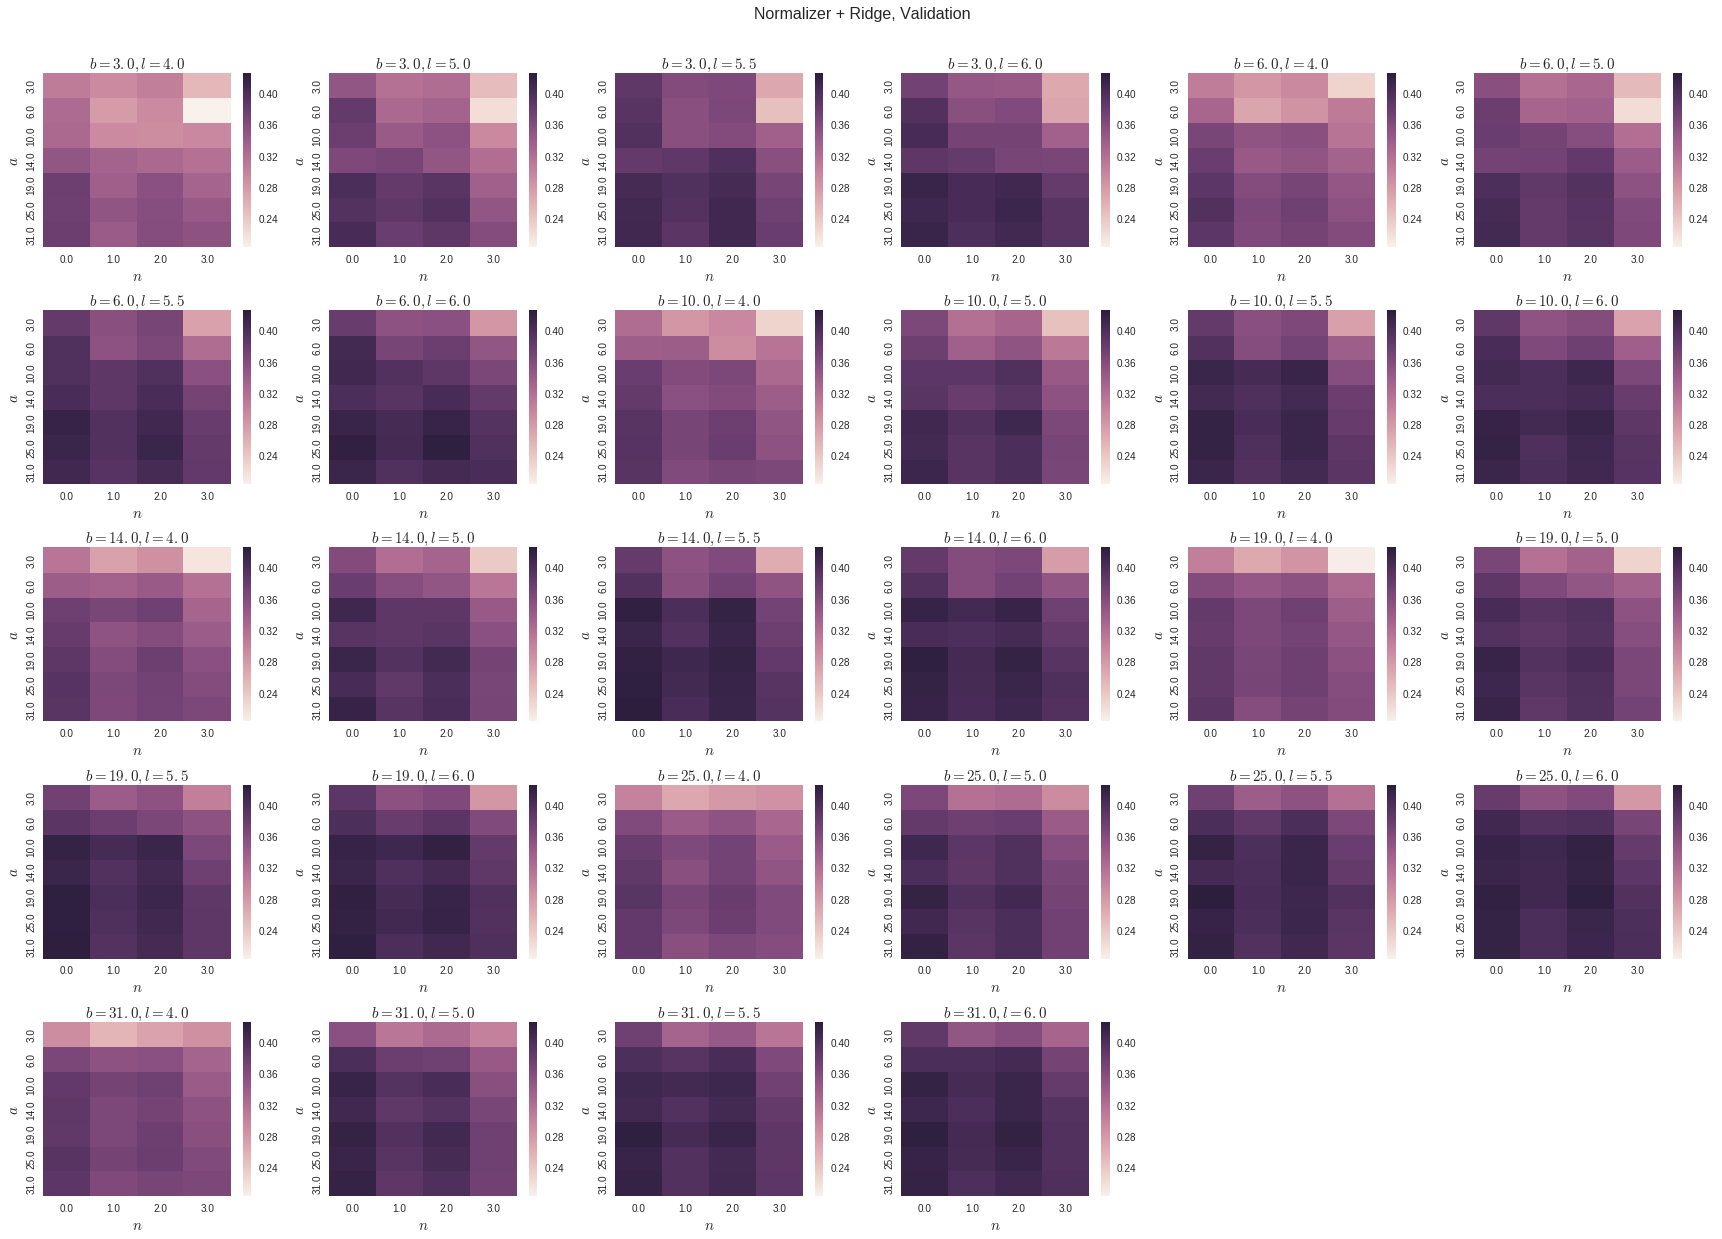

The best:
*hbonds-n0-b14-a31-l5.5-s0--skip_errors.mat


RMSD    TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native     97.469     96.8142      98.4425      98.2876   
Top 1                    0.0309735  0.00442478   0.00442478            0   
Top 5                    0.0752212   0.0530973    0.0309735    0.0265487   
Mean score for top 1       9.07228    0.536192     0.433188     0.470845   
Mean loss score           -6.44568    0.176413     0.176101     0.169332   
Mean Pearson              0.399895   -0.464615    -0.477167     -0.48019   
Mean Spearman             0.338227   -0.356804    -0.370131    -0.373926   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      95.1239        215.376            88.9912   
Top 1                     0.00442478              0          0.0132743   
Top 5                      0.0486726     0.00442478           0.079646   
Mean score for top 1        0.334511        9.07228           0.556916   
Mean loss score             0.141912        54.7628           0.197392   
Mean Pearson               -0.489757       0.399895          -0.504315   
Mean Spearman              -0.388142       0.338213           -0.39333   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                97.1416                94.6106   
Top 1                                0.0176991              0.0132743   
Top 5                                0.0840708              0.0663717   
Mean score for top 1                  0.458614                0.50035   
Mean loss score                       0.274193               0.258499   
Mean Pearson                         -0.492857              -0.503179   
Mean Spearman                        -0.392985              -0.402275   

                        GDT-HA-score-backwards  
Mean rank of the native                 95.615  
Top 1                                0.0221239  
Top 5                                0.0752212  
Mean score for top 1                     0.356  
Mean loss score                       0.247354  
Mean Pearson                          -0.49481  
Mean Spearman                        -0.407289

In [18]:
plot_results(results_val,
             'Normalizer + Ridge', correlation_score,
             params, info='Validation', num_cols=6, figsize=1)

#### Feature normalization

##### Mean score for top 1

plot_results(results_val,
             'MaxAbsScaler + Ridge', mean_top1_score,
             params, info='Validation', num_cols=5, figsize=1)

##### Correlation score 

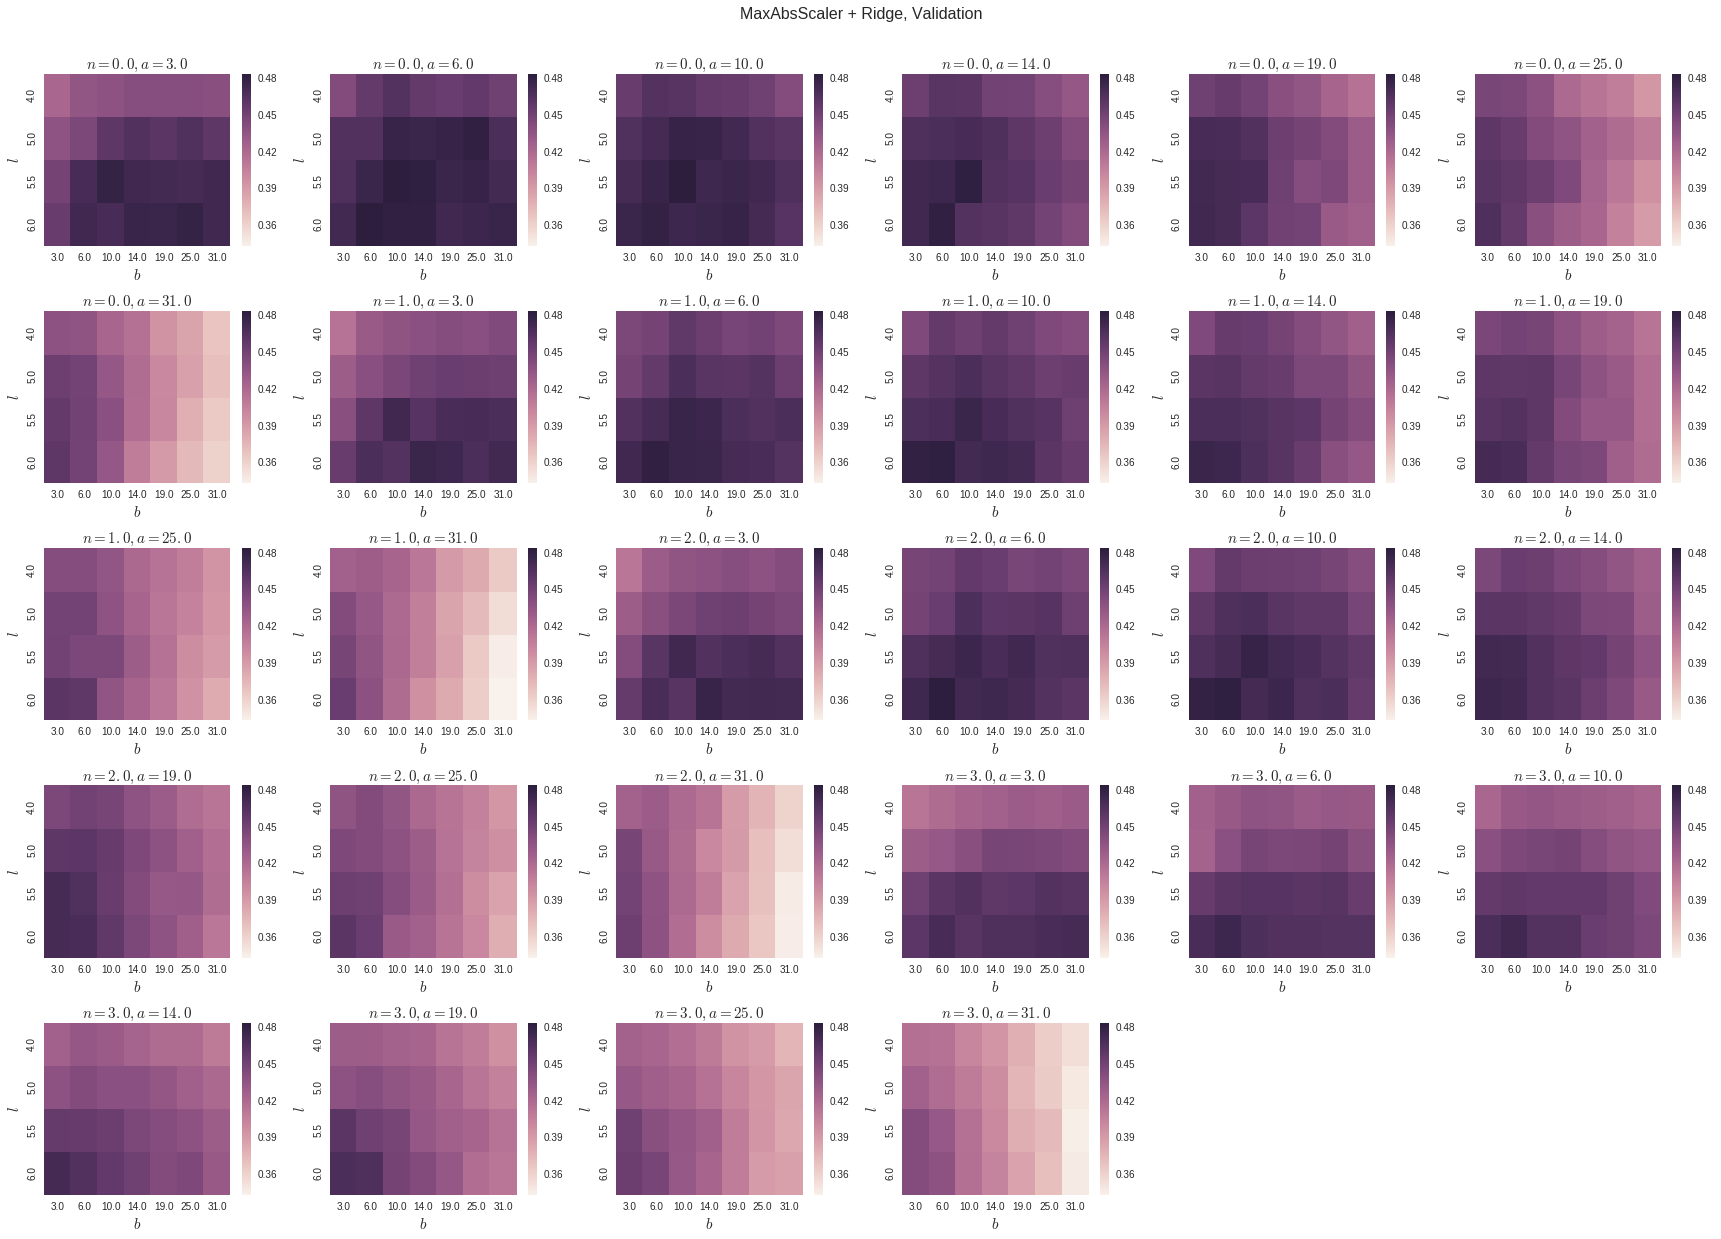

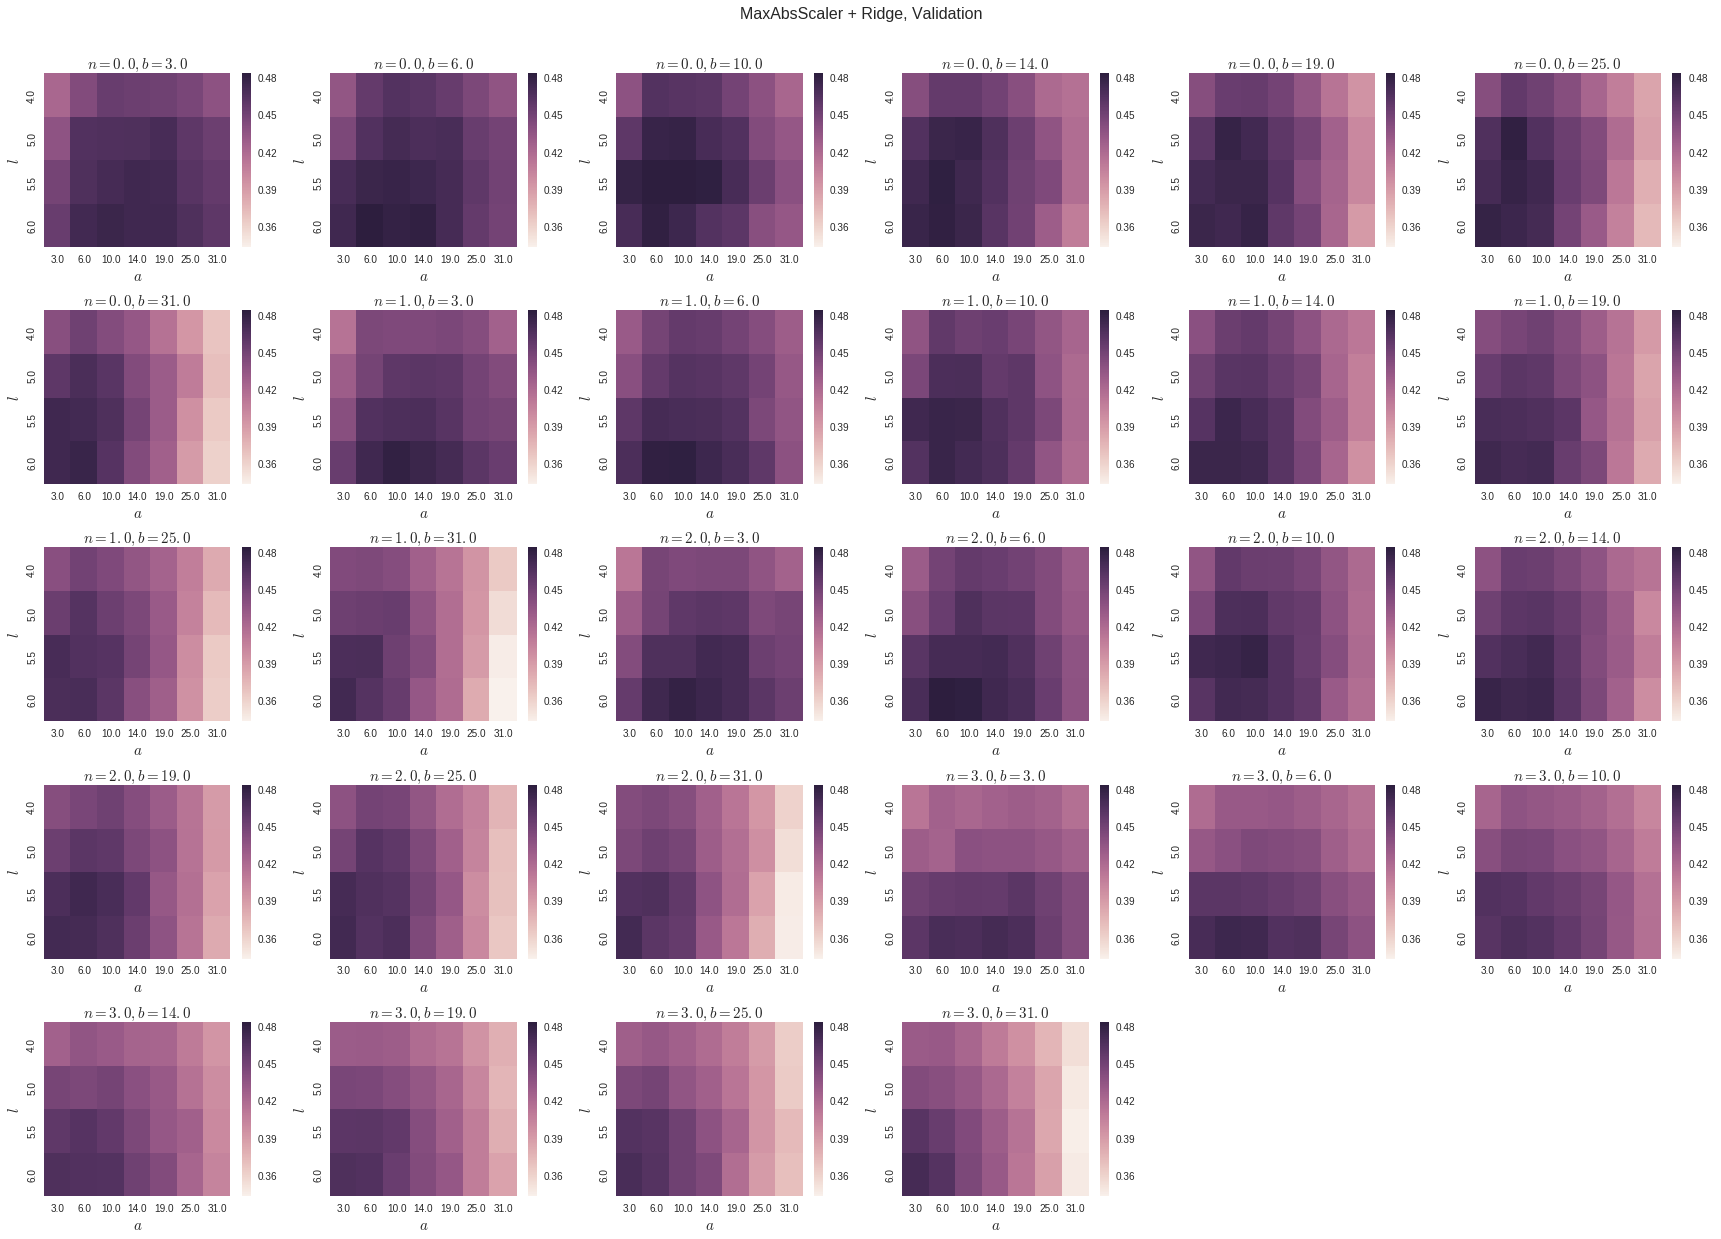

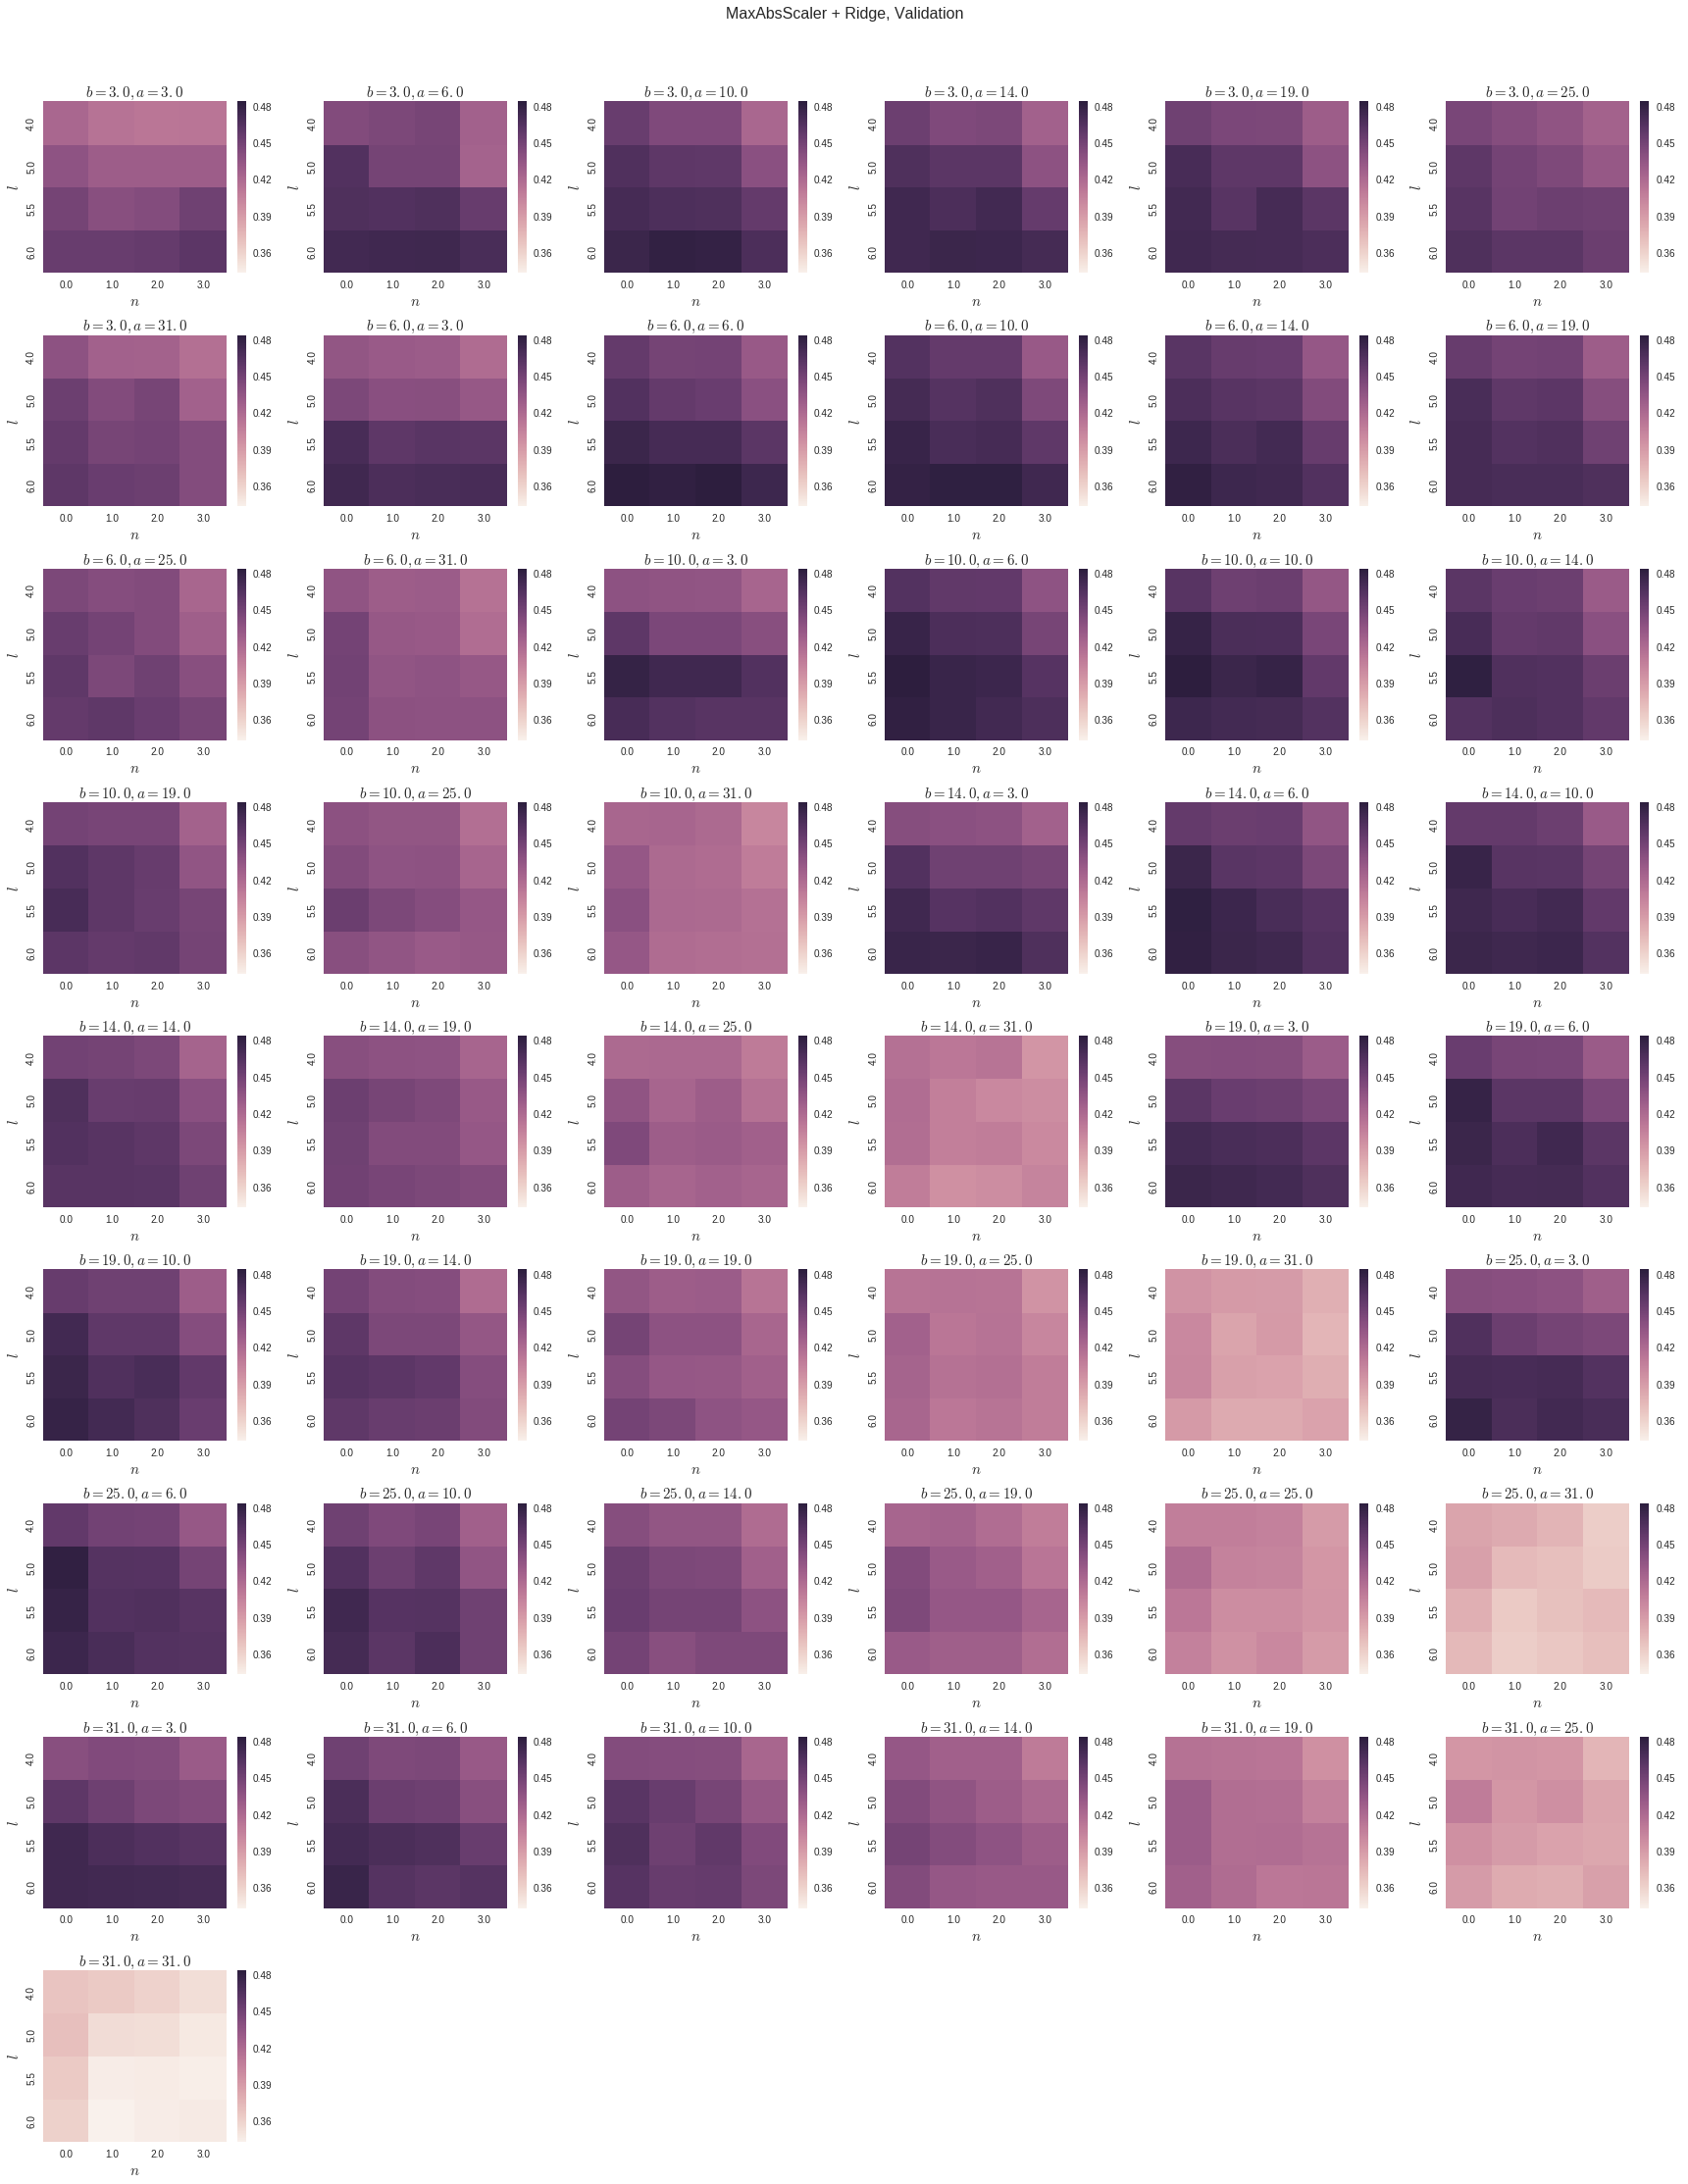

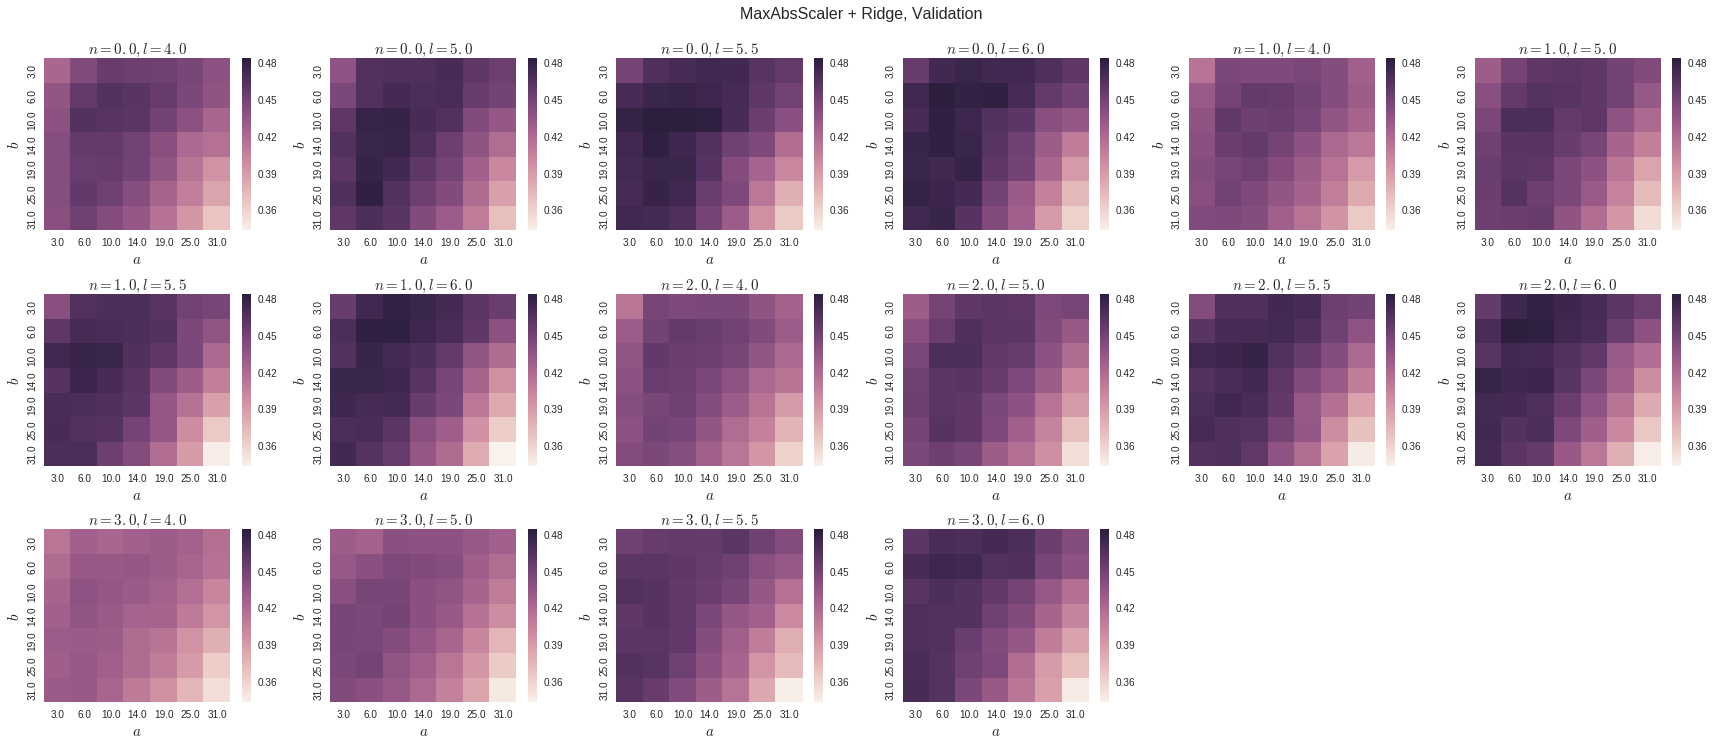

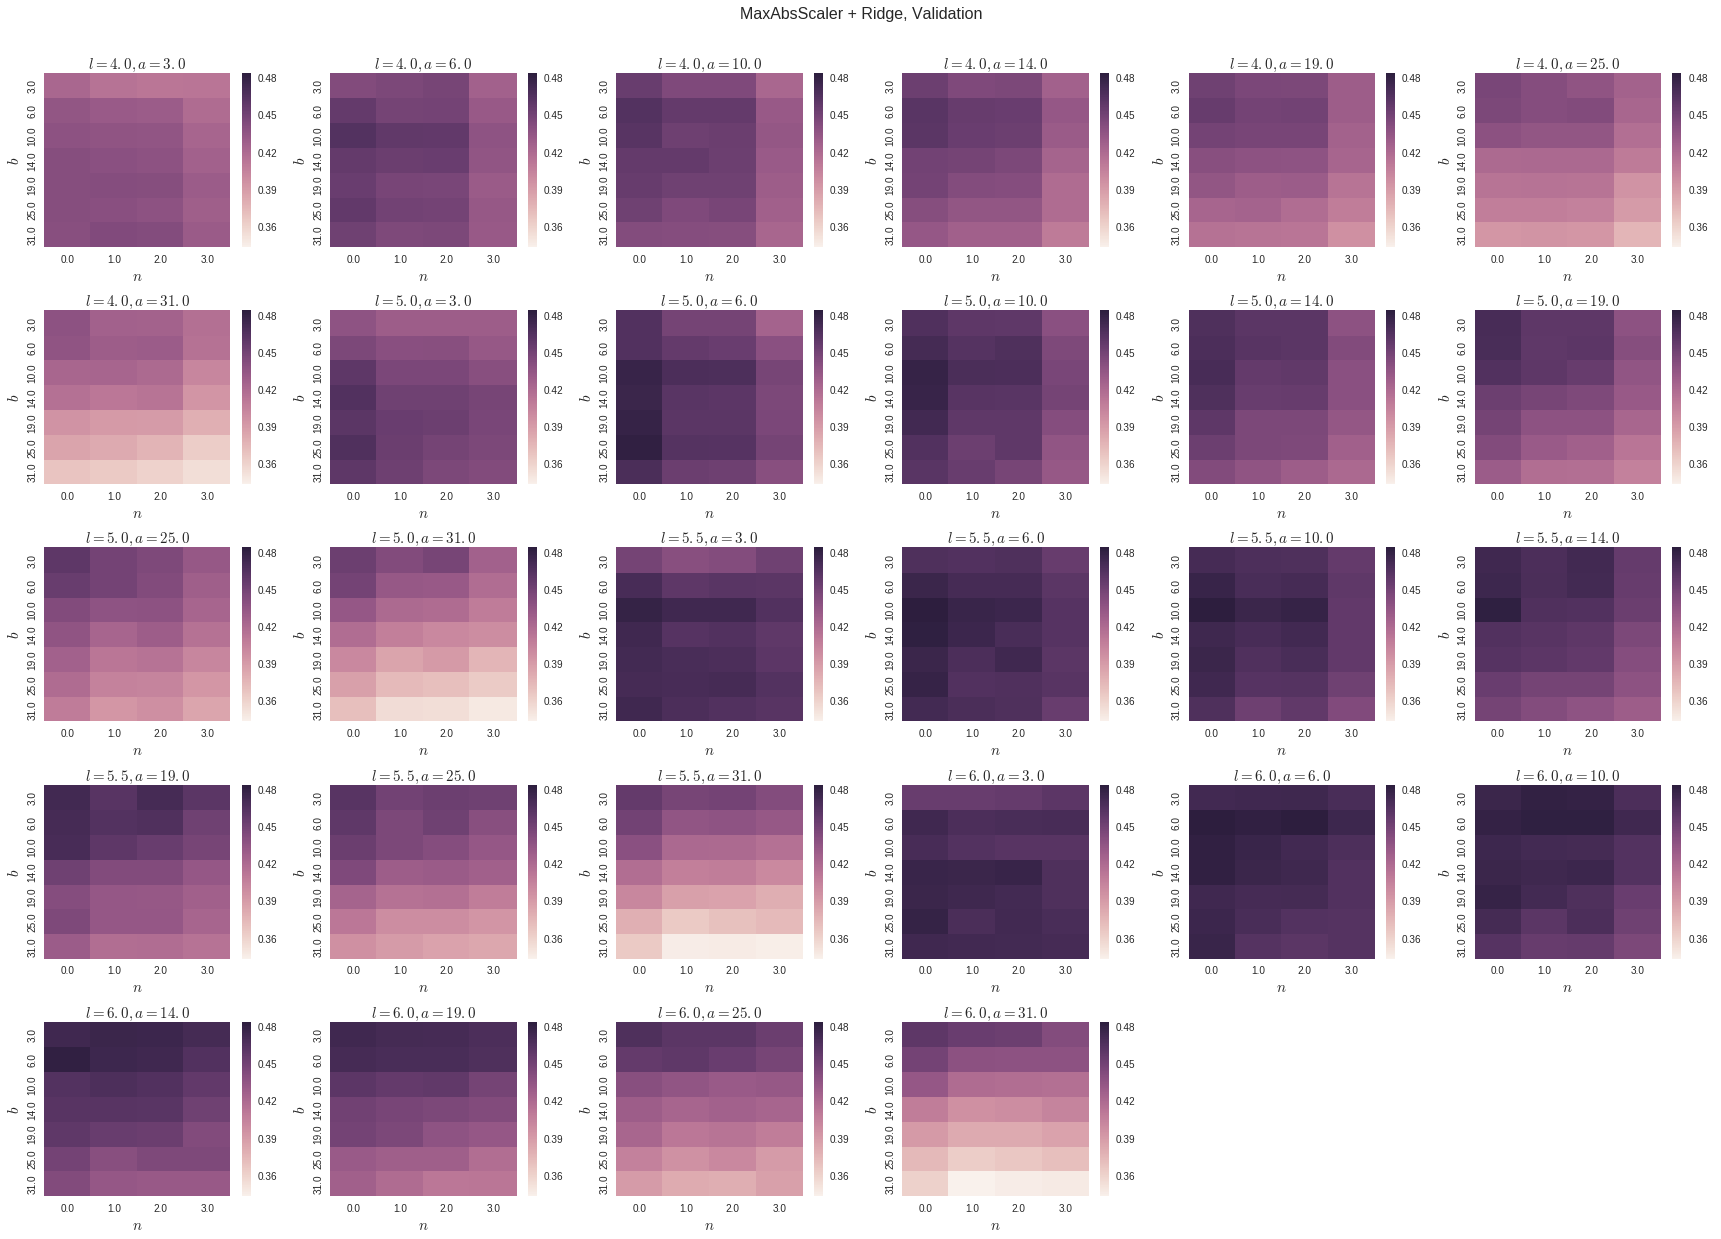

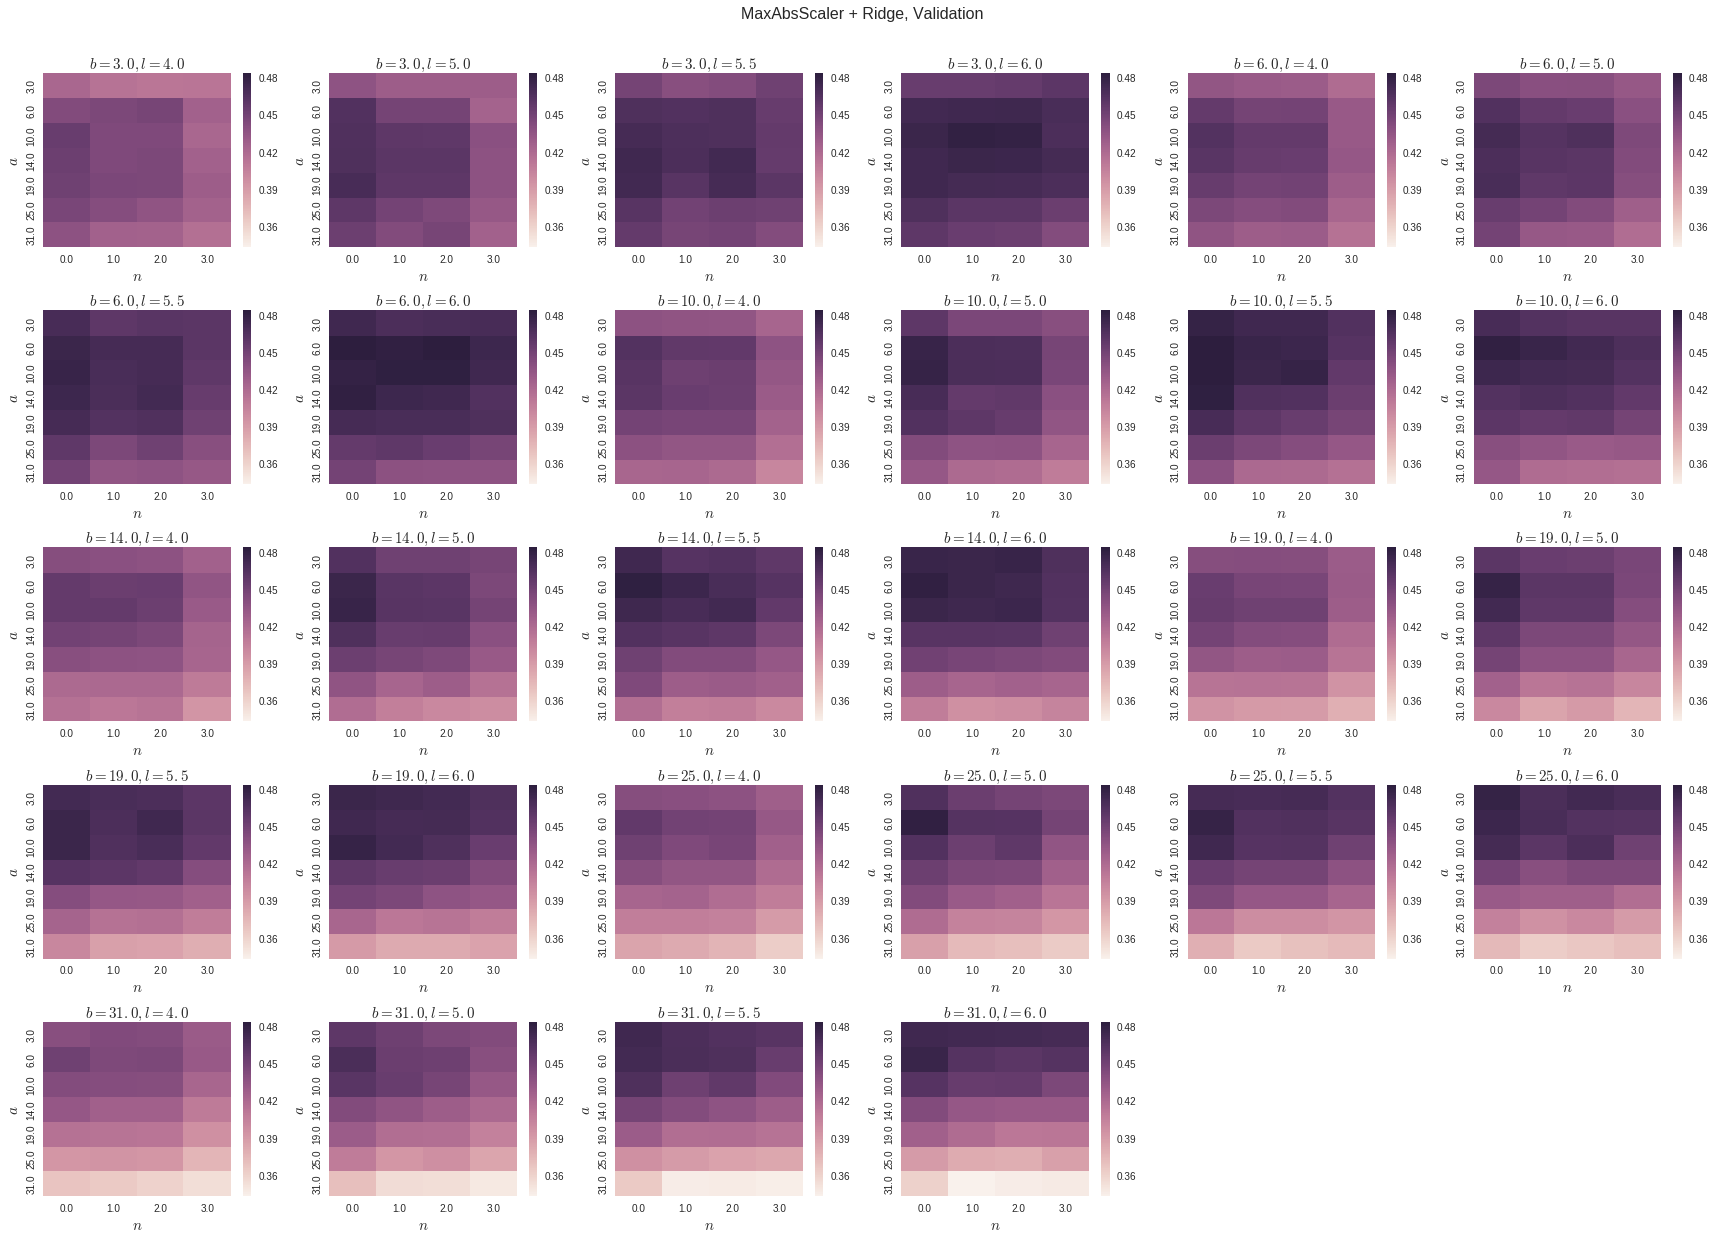

The best:
*hbonds-n2-b6-a6-l6-s0--skip_errors.mat


RMSD    TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native     139.456      91.615      90.2478      86.4071   
Top 1                    0.00442478  0.00884956    0.0132743   0.00442478   
Top 5                     0.0265487   0.0663717    0.0575221    0.0442478   
Mean score for top 1        11.3185    0.553548      0.44413     0.484275   
Mean loss score            -8.69195    0.159057     0.165159     0.155902   
Mean Pearson               0.396693   -0.529449    -0.522136    -0.534611   
Mean Spearman              0.298817   -0.425149    -0.420262    -0.434144   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      86.8053        232.584            111.354   
Top 1                      0.0132743     0.00884956         0.00442478   
Top 5                      0.0619469      0.0132743          0.0309735   
Mean score for top 1         0.34712        11.3185           0.528316   
Mean loss score             0.129302        52.5165           0.225993   
Mean Pearson               -0.537603       0.396693          -0.494903   
Mean Spearman              -0.441617       0.298819          -0.379145   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                 139.27                141.841   
Top 1                                        0                      0   
Top 5                                0.0353982              0.0176991   
Mean score for top 1                  0.418919               0.456107   
Mean loss score                       0.313888               0.302742   
Mean Pearson                         -0.452989              -0.461582   
Mean Spearman                        -0.360611              -0.367188   

                        GDT-HA-score-backwards  
Mean rank of the native                140.947  
Top 1                                        0  
Top 5                                0.0265487  
Mean score for top 1                  0.326768  
Mean loss score                       0.276586  
Mean Pearson                         -0.449905  
Mean Spearman                        -0.375676

In [19]:
plot_results(results_val,
             'MaxAbsScaler + Ridge', correlation_score,
             params, info='Validation', num_cols=6, figsize=1)

## Backup

In [9]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

### Save dump

In [20]:
if len(results_train) == 0:
    raise Exception('Empty results')
joblib.dump((results_train, results_val), theNotebook + '.pkl')

['benchmark_hbonds.pkl']

### Load from dump

In [10]:
results_train, results_val = joblib.load(theNotebook + '.pkl')